In [1]:
## Load required modules
import warnings, sys, os ## system
if not sys.warnoptions:
    warnings.simplefilter("ignore") # ignore warnings

import re
import os
import glob
from datetime import datetime    
import time
import copy
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from itertools import product, combinations
import multiprocessing as mp


from bids import BIDSLayout, BIDSValidator

from nilearn.maskers import NiftiMasker
from nilearn import plotting, image
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Load files 
story_dir = '/mnt/c/Users/since/Dropbox/Lab/Projects/CJY/_DATA'
May_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'

In [2]:
#Subject check 
base_dir = '/mnt/c/Users/since/Desktop/KdramaMay/'
data_dir = os.path.join(base_dir, 'data', 'derivatives')
file_list = glob.glob(os.path.join(data_dir, 'sub-*', 'func', f'*task-encoding_run-1_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz'))

sub_sm =[] 
for filename in file_list: 
    sub = os.path.basename(filename).split('_')[0]
    sub = os.path.basename(sub).split('-')[1]
    sub_sm.append(int(sub)) 
print(sub_sm)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 51, 52, 54, 55, 57, 58, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76]


In [2]:
#Subject check 
sub_sm = np.arange(1,77)
sub_sm_exclude = [0, 8, 25] #exclude 9 & 26
subjects = np.delete(sub_sm, sub_sm_exclude)
#print(subject)
print(subjects)

[ 2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76]


In [3]:
# load story sequence 
import scipy.io as sio

all_story = {}
# Load May Data
for sub in sub_sm:
    #print(sub)
    mat = sio.loadmat(glob.glob(os.path.join(story_dir, 'fMRItdsgn', f'sub-{sub}_*.mat'))[0])
    story = []
    for i in np.arange(0,4):
        temp = mat['subj'][0][0][7][0][i][0]
        if temp == 'Blind Date':
            temp = 'BlindDate'
        elif temp == 'Runningman':
            temp = 'RunningMan'
        elif temp == 'neighbors':
            temp = 'Neighbors'
        story = np.append(story, temp)
    #all_story[str(int(sub)+8)] = story
    all_story[sub] = story
#Fix story sequence
#story_sequece = all_story[]
#story_sequece

# Just for Events

In [41]:
# EB condition 

vis_eb =  {'run' : [15,42,65,85,147,180], 'nei': [15,32,111,140,180], 'dream': [15,41,98,132,165], 'blind': [15,19,72,90,156,180]}
aud_eb = {'run' : [15,39,73,85,147,180], 'nei': [15,64,93,107,140,180], 'dream': [15,25,40,98,133,158,180], 'blind': [15,54,131,155,180]}
event_boundary = {'vis': vis_eb, 'aud':aud_eb}
eb_events_list = []
for story in np.arange(0,4):    
    
    thisStory = storyName[all_story[sub][story]] 
    
    for eb in ['vis','aud']:
        boundary = event_boundary[eb]
        duration = np.full(len(boundary[thisStory]), 1.5)
        
        for event in range(len(boundary[thisStory])):
                        
            eb_events_list.append({
                'onset': onset[cond][story] + boundary[thisStory][event],
                'duration':duration[event],
                'trial_type': f'{thisStory}{event}boundary'
            })

# Convert to DataFrame
eb_events = pd.DataFrame(eb_events_list)

# print(events)
# preEvent condition 
vis_onset = {'run' : [15,42,65,85,147], 'nei': [15,32,111,140], 'dream': [15,41,98,132], 'blind': [15,19,72,90,156]}
aud_onset = {'run' : [15,39,73,85,147], 'nei': [15,64,93,107,140], 'dream': [15,25,40,98,133,158], 'blind': [15,54,131,155]}
event_onset = {'vis': vis_onset, 'aud':aud_onset}
onset_events_list = []

for story in np.arange(0,4):    
    
    thisStory = storyName[all_story[sub][story]] 
    
    for eb in ['vis','aud']:
        start = event_onset[eb]
        duration = np.full(len(start[thisStory]), 6)
        
        for event in range(len(start[thisStory])):
                        
            onset_events_list.append({
                'onset': onset[cond][story] + 3 + start[thisStory][event],
                'duration':duration[event],
                'trial_type': f'{thisStory}{event}pre'
            })

# Convert to DataFrame
onset_events = pd.DataFrame(onset_events_list)
#print(onset_events)

#postEvent condition 
vis_offset = {'run' : [42,65,85,147,180], 'nei': [32,111,140,180], 'dream': [41,98,132,165], 'blind': [19,72,90,156,180]}
aud_offset = {'run' : [39,73,85,147,180], 'nei': [64,93,107,140,180], 'dream': [25,40,98,133,158,180], 'blind': [54,131,155,180]}

event_offset = {'vis': vis_offset, 'aud':aud_offset}
offset_events_list = []

for story in np.arange(0,4):    
    
    thisStory = storyName[all_story[sub][story]] 
    
    for eb in ['vis','aud']:
        end = event_offset[eb]
        duration = np.full(len(end[thisStory]), 4.5)
        
        for event in range(len(end[thisStory])):
                        
            offset_events_list.append({
                'onset': onset[cond][story] + end[thisStory][event] - 9,
                'duration':duration[event],
                'trial_type': f'{thisStory}{event}post'
            })

# Convert to DataFrame
offset_events = pd.DataFrame(offset_events_list)
print(offset_events)


    onset  duration  trial_type
0      23       4.5    nei0post
1     102       4.5    nei1post
2     131       4.5    nei2post
3     171       4.5    nei3post
4      55       4.5    nei0post
5      84       4.5    nei1post
6      98       4.5    nei2post
7     131       4.5    nei3post
8     171       4.5    nei4post
9     213       4.5    run0post
10    236       4.5    run1post
11    256       4.5    run2post
12    318       4.5    run3post
13    351       4.5    run4post
14    210       4.5    run0post
15    244       4.5    run1post
16    256       4.5    run2post
17    318       4.5    run3post
18    351       4.5    run4post
19    355       4.5  blind0post
20    408       4.5  blind1post
21    426       4.5  blind2post
22    492       4.5  blind3post
23    516       4.5  blind4post
24    390       4.5  blind0post
25    467       4.5  blind1post
26    491       4.5  blind2post
27    516       4.5  blind3post
28    572       4.5  dream0post
29    629       4.5  dream1post
30    66

In [29]:
thisStory

'dream'

In [45]:
events = pd.concat([eb_events, onset_events, offset_events])

# 1. EB/Pre/Post

## Building Desing Matrix & Fitting : EB/pre/post

In [24]:
# make DM for each subject 
onset = {'Dream1': [0, 165, 345, 525], 'Dream2': [0, 180, 345, 525], 'Dream3': [0, 180, 360, 525], 'Dream4': [0, 180, 345, 540]}
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}
sub_dm = {} 
for sub in subjects:
    print(sub)
    
    # Generate the events data frame
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    cond = 'Dream'+str(int(sequence)+1)
    
    
    # EB condition 
    vis_eb =  {'run' : [15,42,65,85,147,180], 'nei': [15,32,111,140,180], 'dream': [15,41,98,132,165], 'blind': [15,19,72,90,156,180]}
    aud_eb = {'run' : [15,39,73,85,147,180], 'nei': [15,64,93,107,140,180], 'dream': [15,25,40,98,133,158,180], 'blind': [15,54,131,155,180]}
    event_boundary = {'vis': vis_eb, 'aud':aud_eb}
    eb_events_list = []
    for story in np.arange(0,4):    

        thisStory = storyName[all_story[sub][story]] 

        for eb in ['vis','aud']:
            boundary = event_boundary[eb]
            duration = np.full(len(boundary[thisStory]), 1.5)

            for event in range(len(boundary[thisStory])):
                
                if eb == 'vis':
                 
                    eb_events_list.append({
                        'onset': onset[cond][story] + boundary[thisStory][event],
                        'duration':duration[event],
                        'trial_type': 'boundary'
                    })

                else: 
                    eb_events_list.append({
                        'onset': 477 + onset[cond][story] + boundary[thisStory][event],
                        'duration':duration[event],
                        'trial_type': 'boundary'
                    })

    # Convert to DataFrame
    eb_events = pd.DataFrame(eb_events_list)

    # print(events)
    # preEvent condition 
    vis_onset = {'run' : [15,42,65,85,147], 'nei': [15,32,111,140], 'dream': [15,41,98,132], 'blind': [15,19,72,90,156]}
    aud_onset = {'run' : [15,39,73,85,147], 'nei': [15,64,93,107,140], 'dream': [15,25,40,98,133,158], 'blind': [15,54,131,155]}
    event_onset = {'vis': vis_onset, 'aud':aud_onset}
    onset_events_list = []

    for story in np.arange(0,4):    

        thisStory = storyName[all_story[sub][story]] 

        for eb in ['vis','aud']:
            start = event_onset[eb]
            duration = np.full(len(start[thisStory]), 6)

            for event in range(len(start[thisStory])):
                
                if eb == 'vis':

                    onset_events_list.append({
                        'onset': onset[cond][story] + 3 + start[thisStory][event],
                        'duration':duration[event],
                        'trial_type': 'pre'
                    })
                else: 

                    onset_events_list.append({
                        'onset': 477+ onset[cond][story] + 3 + start[thisStory][event],
                        'duration':duration[event],
                        'trial_type': 'pre'
                    })

    # Convert to DataFrame
    onset_events = pd.DataFrame(onset_events_list)
    #print(onset_events)

    #postEvent condition 
    vis_offset = {'run' : [42,65,85,147,180], 'nei': [32,111,140,180], 'dream': [41,98,132,165], 'blind': [19,72,90,156,180]}
    aud_offset = {'run' : [39,73,85,147,180], 'nei': [64,93,107,140,180], 'dream': [25,40,98,133,158,180], 'blind': [54,131,155,180]}

    event_offset = {'vis': vis_offset, 'aud':aud_offset}
    offset_events_list = []

    for story in np.arange(0,4):    

        thisStory = storyName[all_story[sub][story]] 

        for eb in ['vis','aud']:
            end = event_offset[eb]
            duration = np.full(len(end[thisStory]), 4.5)

            for event in range(len(end[thisStory])):
                if eb == 'vis':
                
                    offset_events_list.append({
                        'onset': onset[cond][story] + end[thisStory][event] - 9,
                        'duration':duration[event],
                        'trial_type': 'post'
                    })
                else: 
                    
                    offset_events_list.append({
                        'onset': 477 + onset[cond][story] + end[thisStory][event] - 9,
                        'duration':duration[event],
                        'trial_type': 'post'
                    })


    # Convert to DataFrame
    offset_events = pd.DataFrame(offset_events_list)
    
    
    #Story 
    events_list = []
    for story in np.arange(0,4):    
        
        thisStory = storyName[all_story[sub][story]] 
        
        for eb in ['vis','aud']:
            start = event_onset[eb]
            end = event_offset[eb]
            
            duration = [ai - bi for ai, bi in zip(end[thisStory], start[thisStory])]

            for event in range(len(start[thisStory])):
                if eb == 'vis': 
                    events_list.append({
                        'onset': onset[cond][story] + start[thisStory][event],
                        'duration': duration[event],
                        'trial_type': f'{thisStory}{event}'
                    })
                else: 
                    events_list.append({
                        'onset': 477+ onset[cond][story] + start[thisStory][event],
                        'duration': duration[event],
                        'trial_type': f'{thisStory}{event}'
                    })
                    
    story_events = pd.DataFrame(events_list)
    
    #codition 
    session_list = [] 
    start = [1,715] 
    duration = [714,714] 
    for num, eb in enumerate(['vis','aud']):
        session_list.append({
        'onset': start[num],
        'duration': duration[num],
        'trial_type': f'{eb}'
        })  

    session_events = pd.DataFrame(session_list)
    #print(session_events)

    events = pd.concat([eb_events, onset_events, offset_events, story_events, session_events])
    sub_dm[sub] = events
    
#print(events)

2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33


## Fitting DM : EB/pre/post

2
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
3
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
4
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
5
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
6
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
7
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
8
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
10
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
11
event_size (162, 3)
desingMatrix_size (954, 55)
Load concatenated func_img f

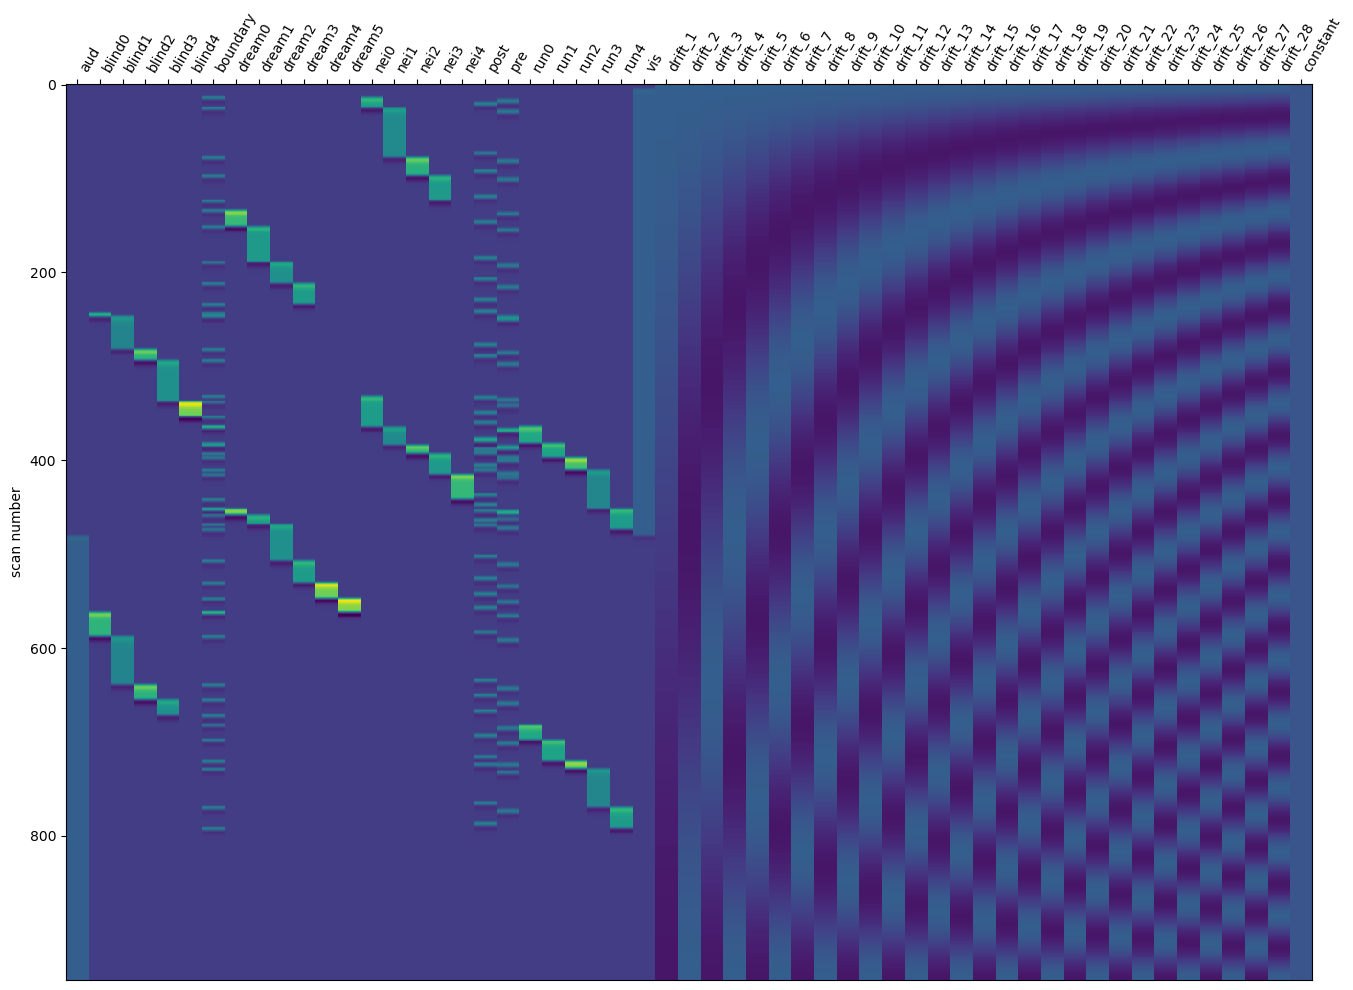

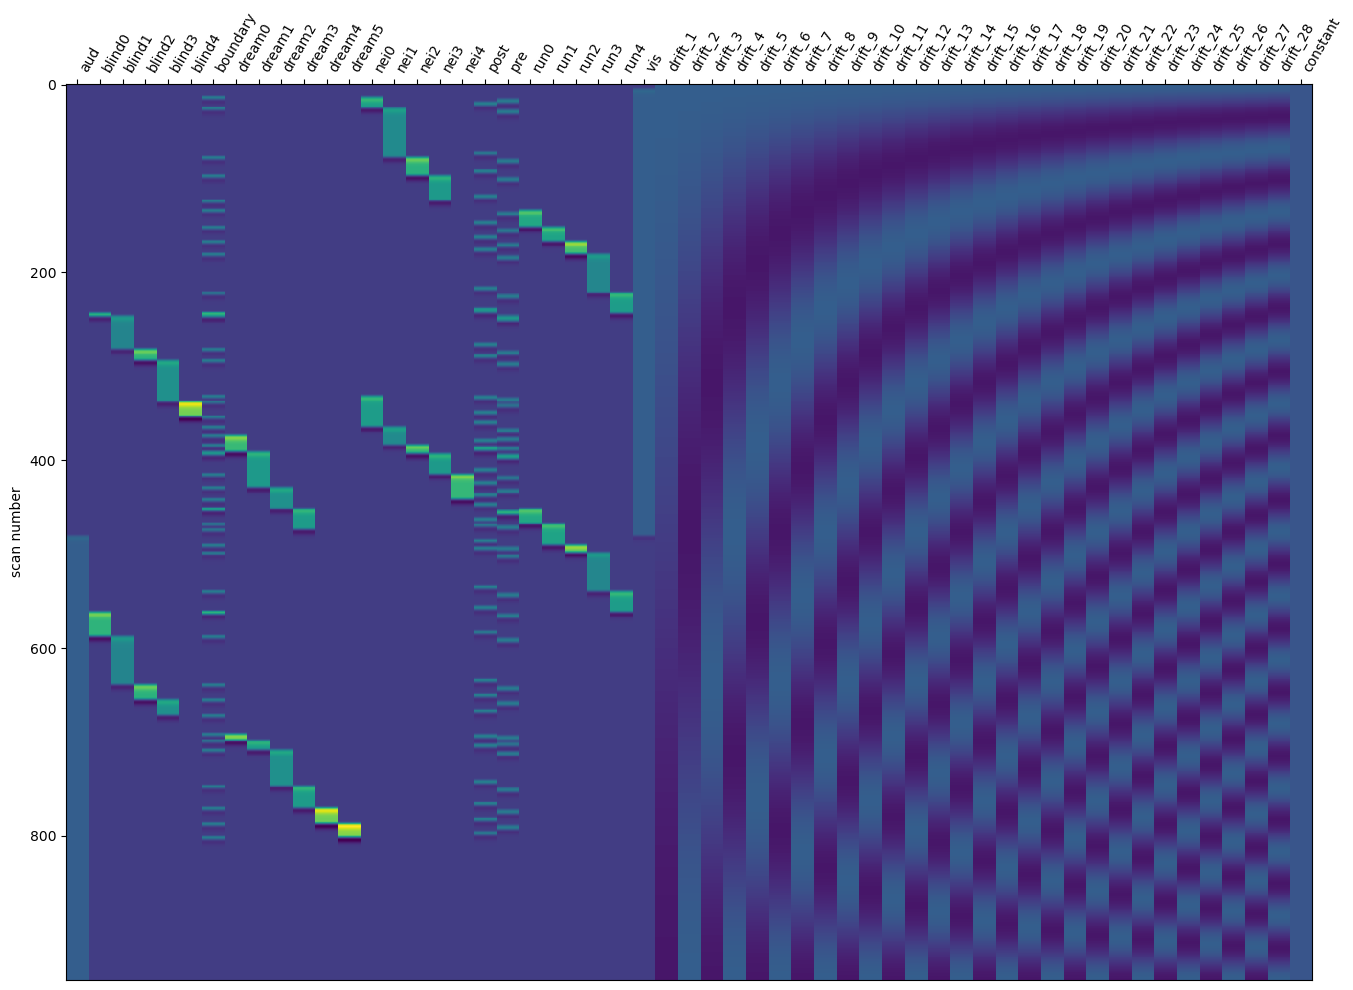

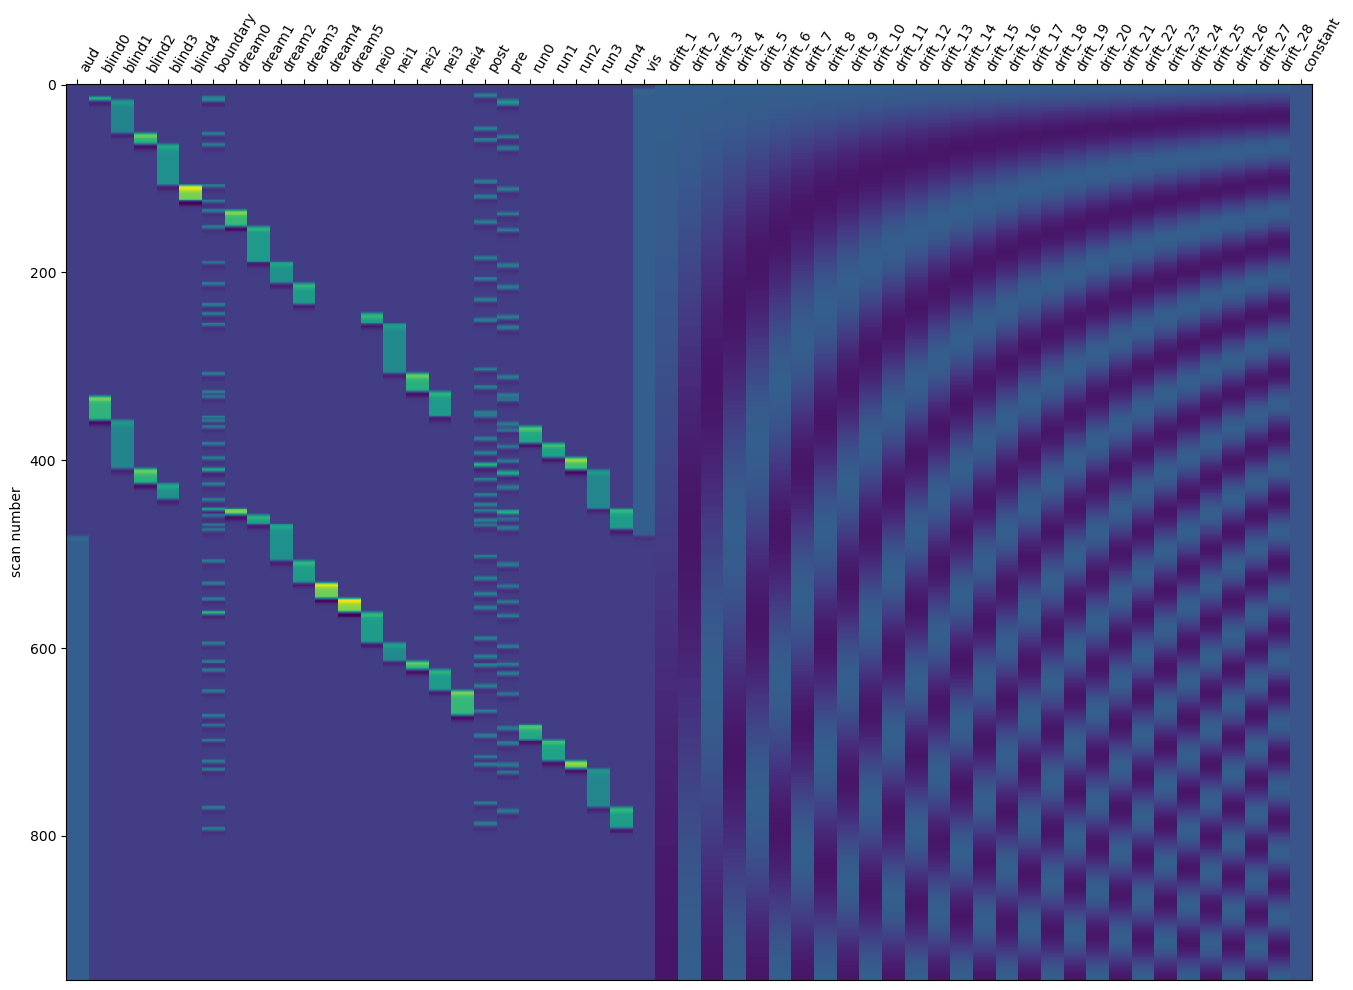

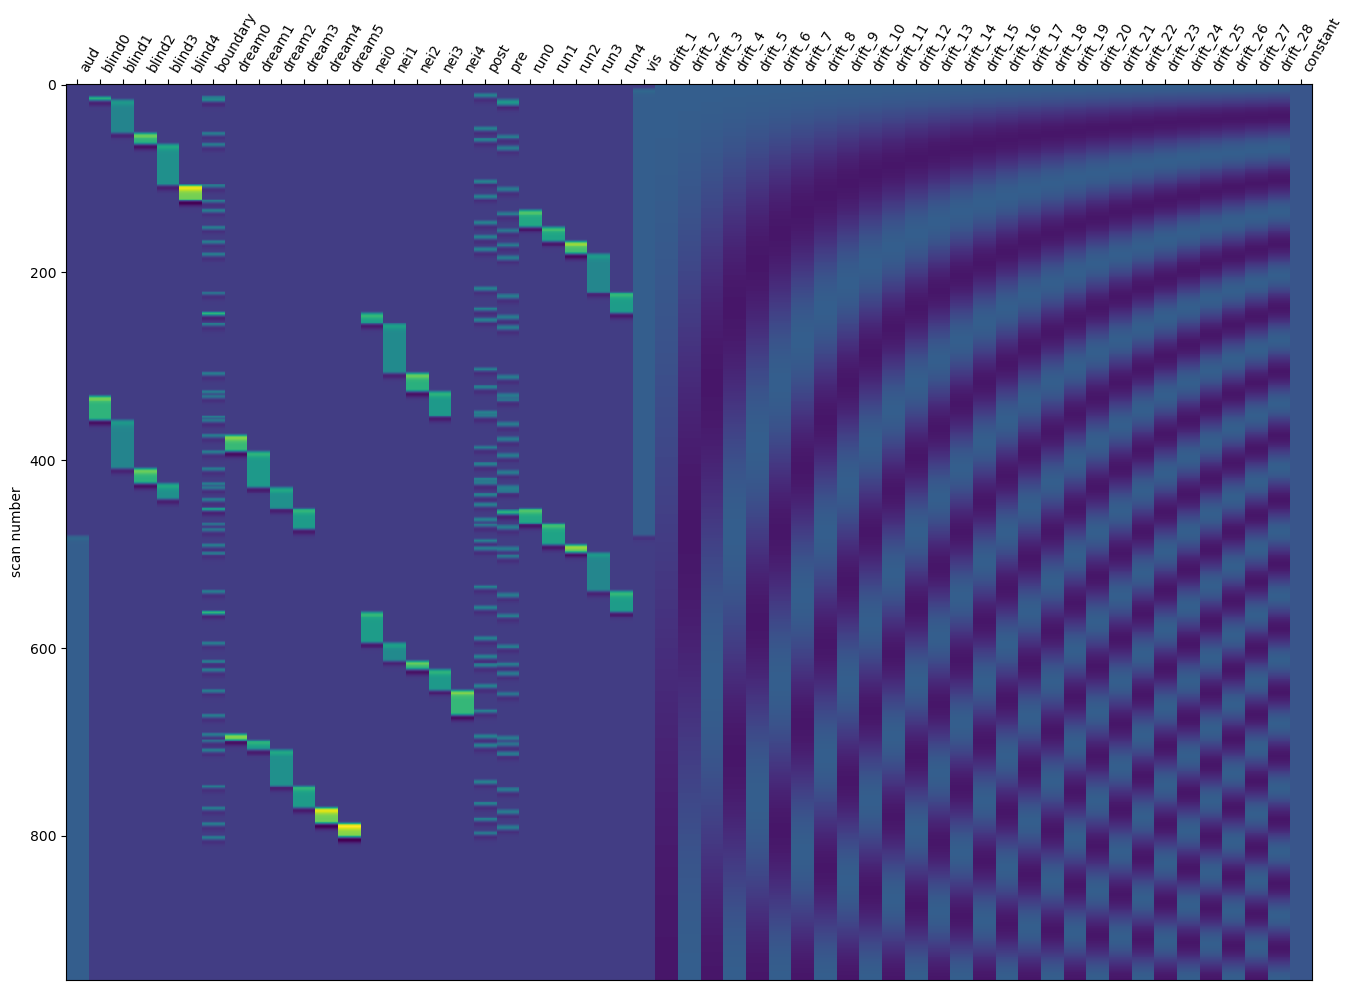

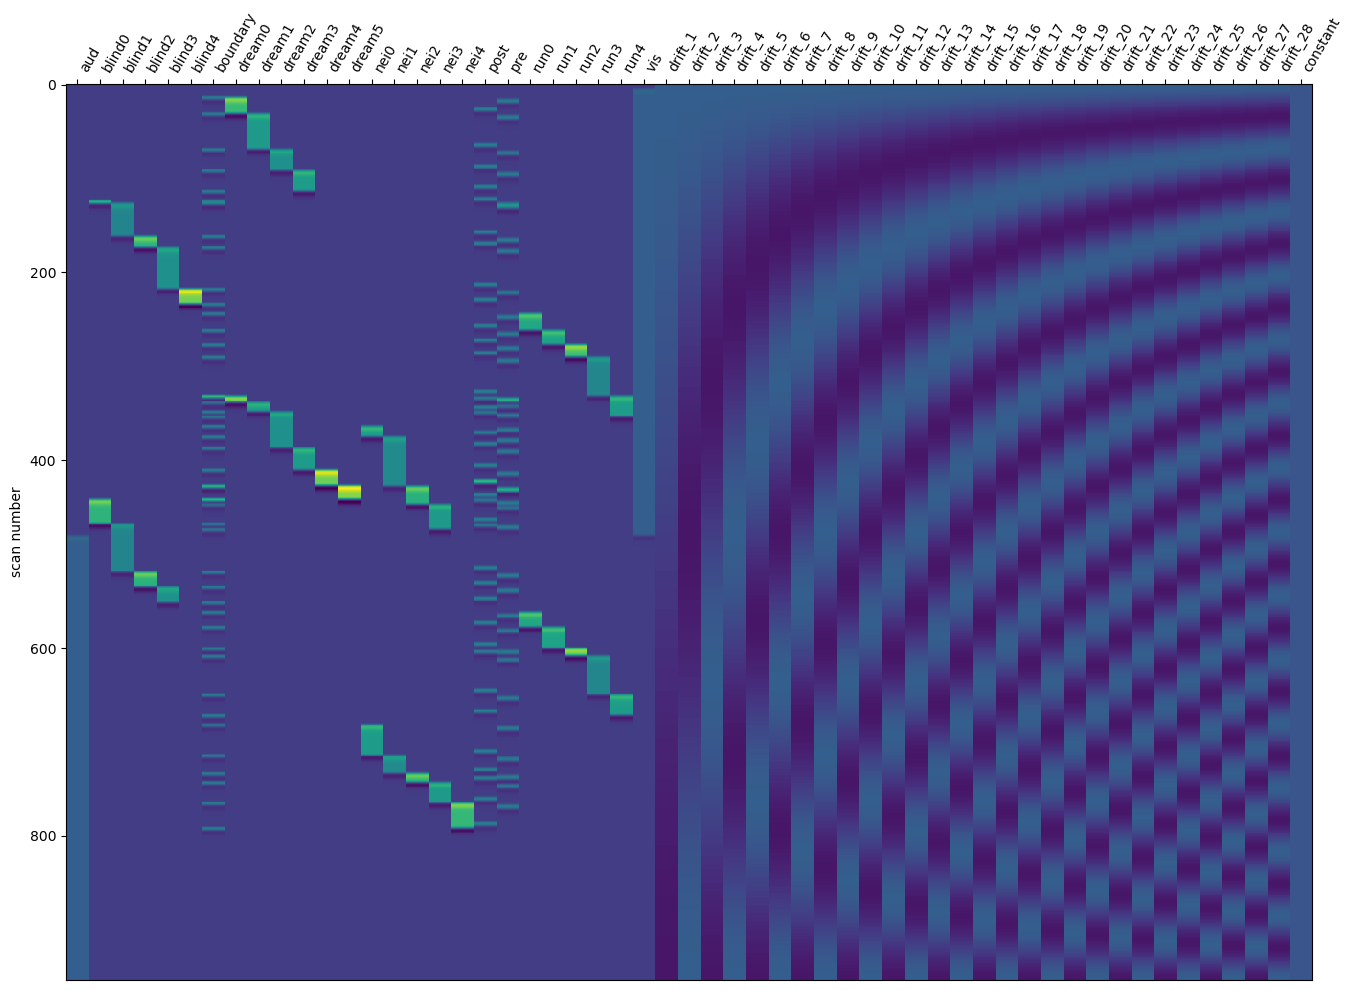

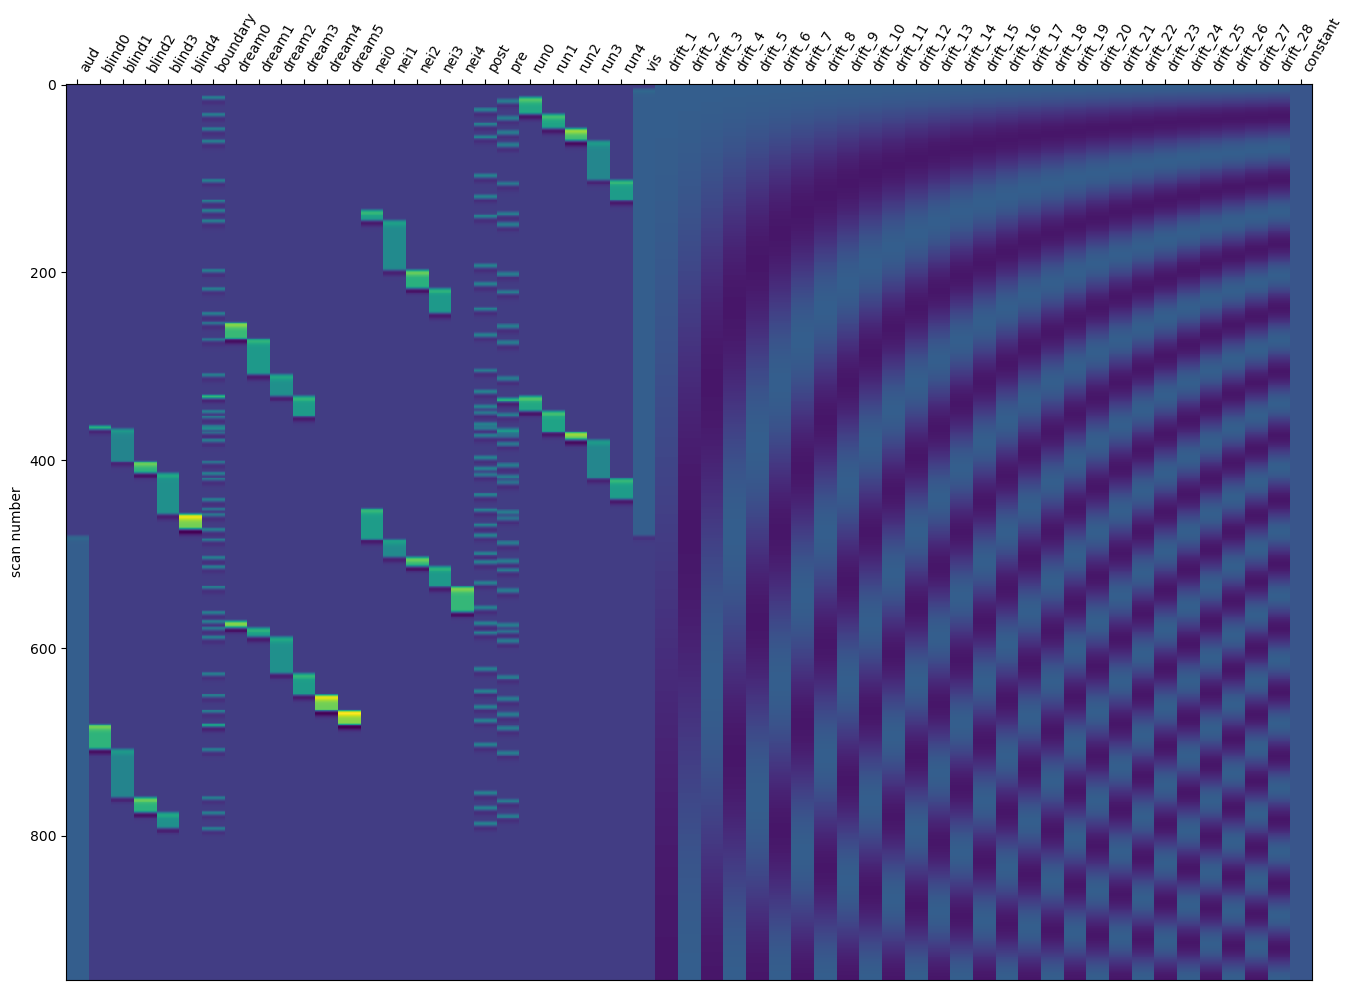

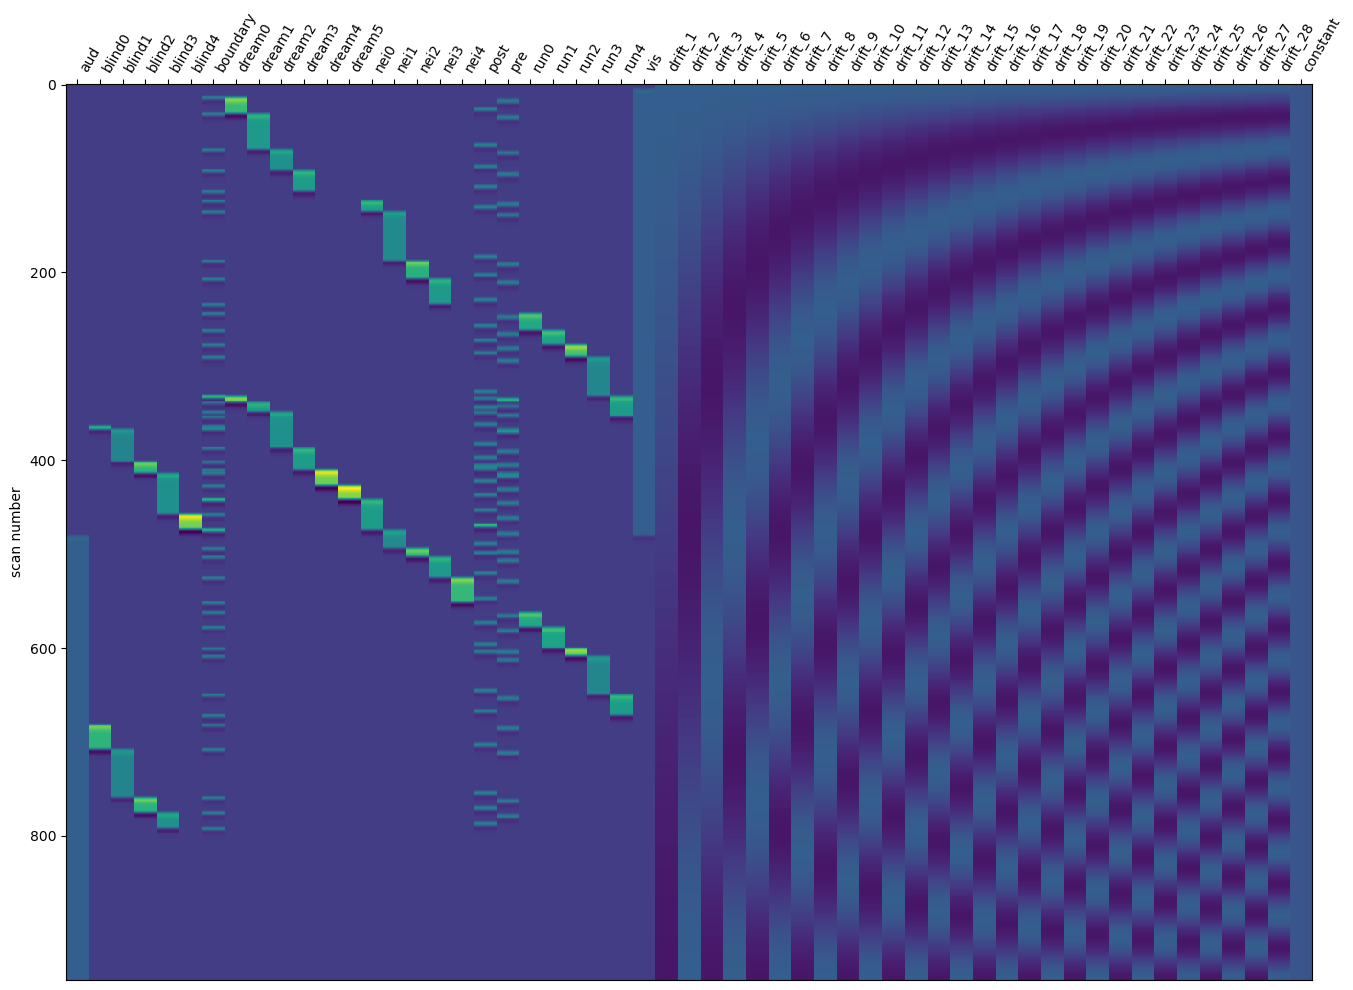

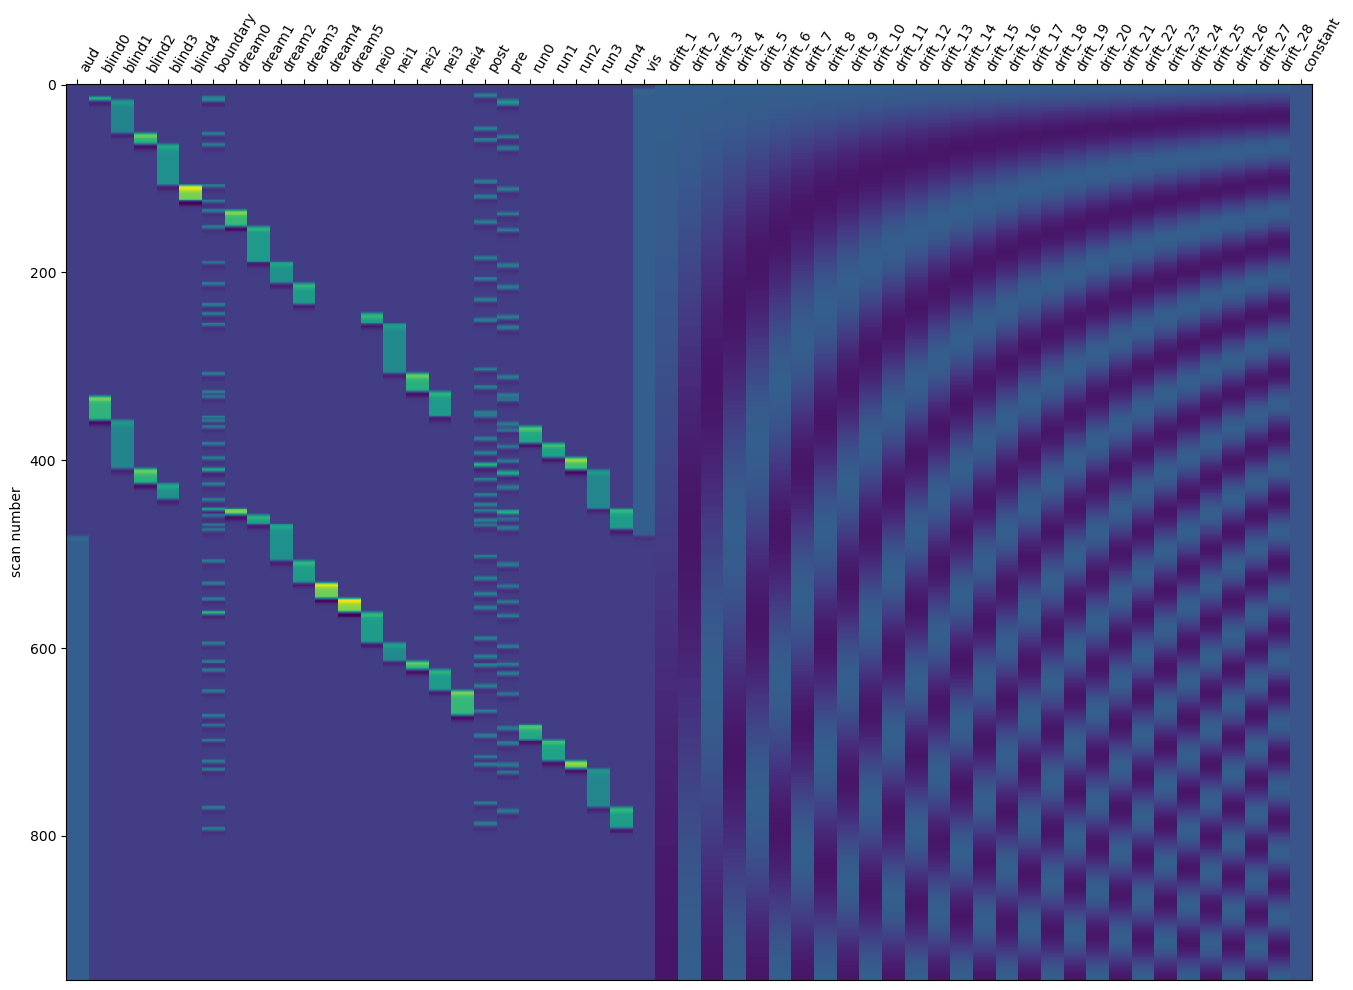

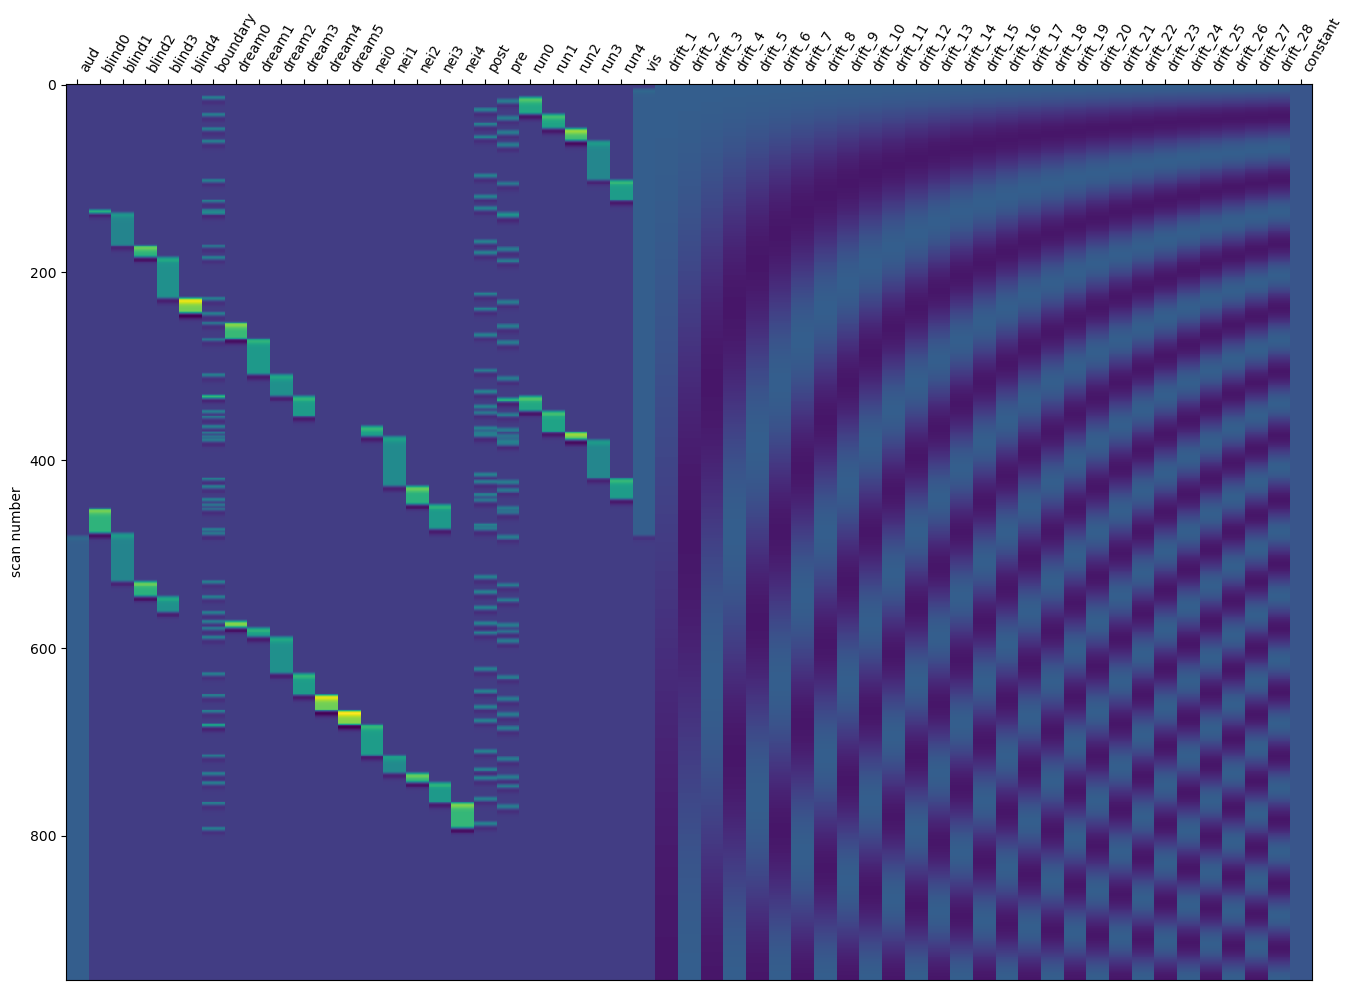

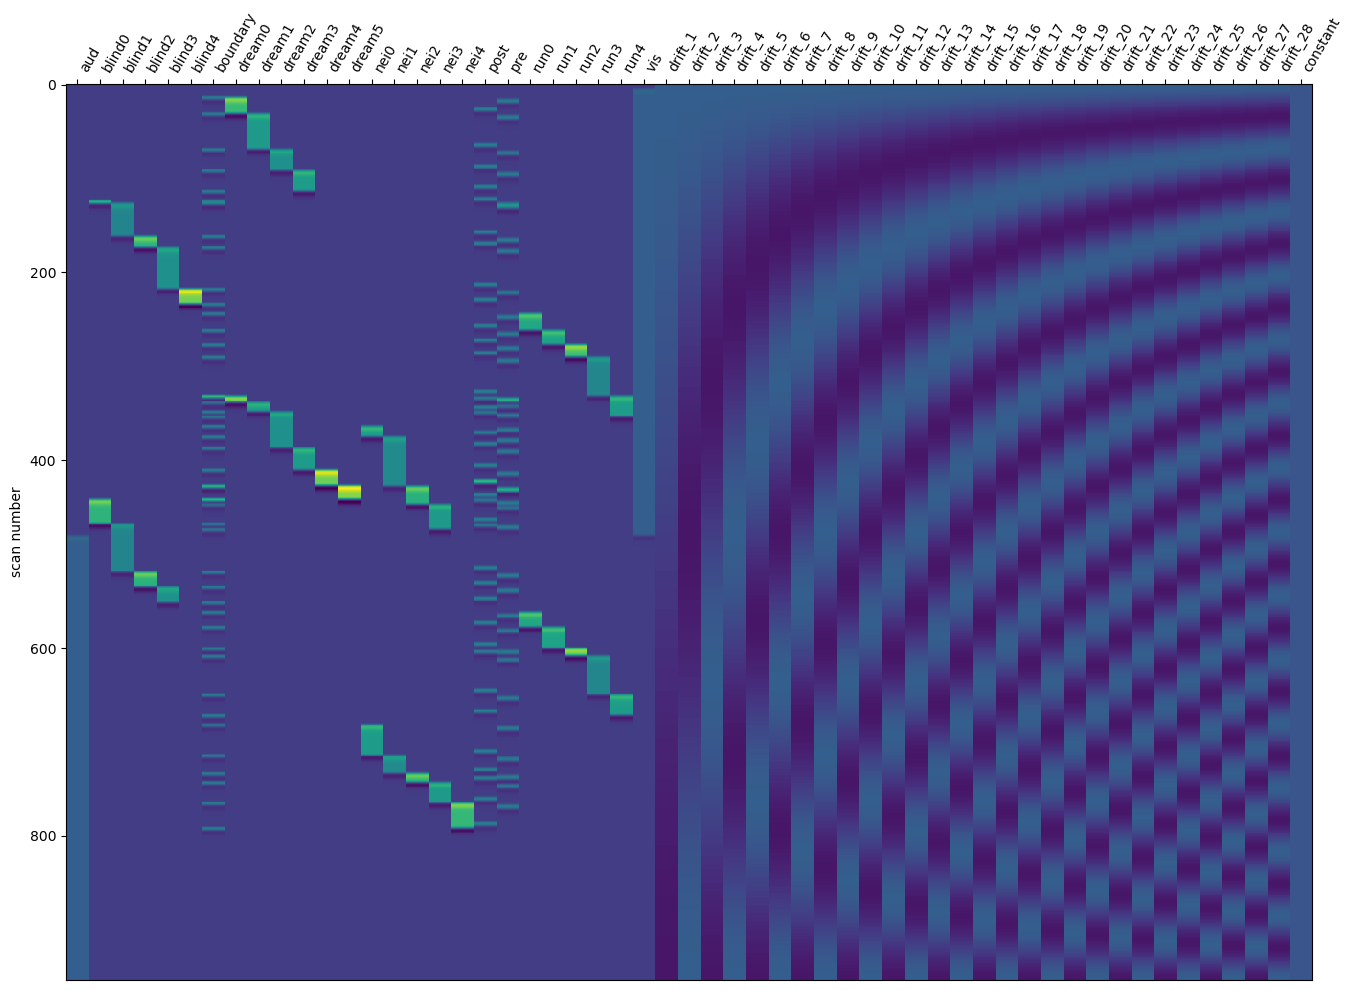

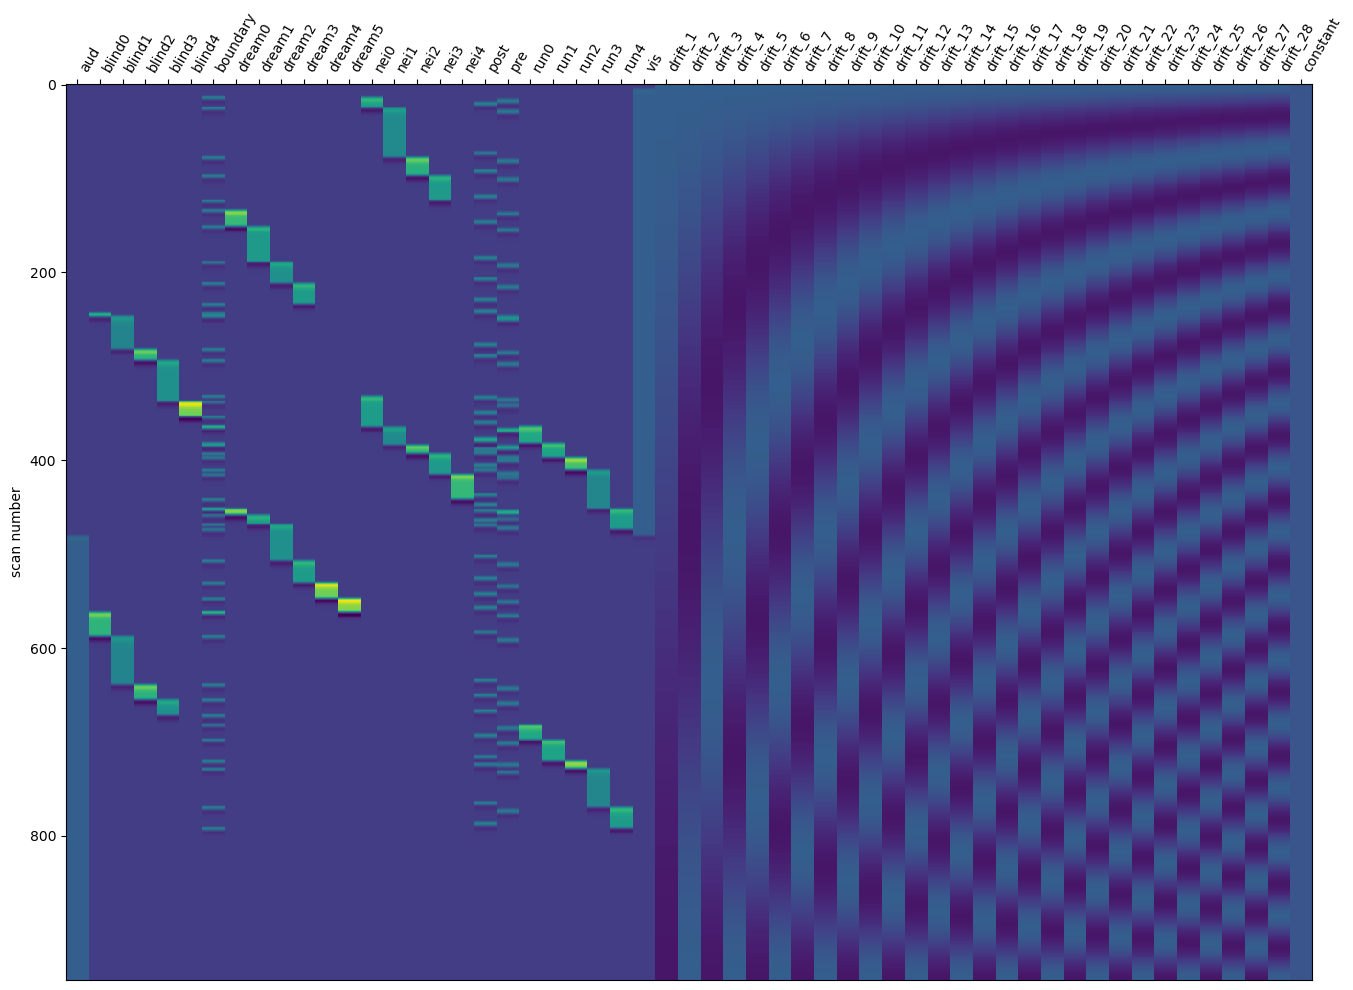

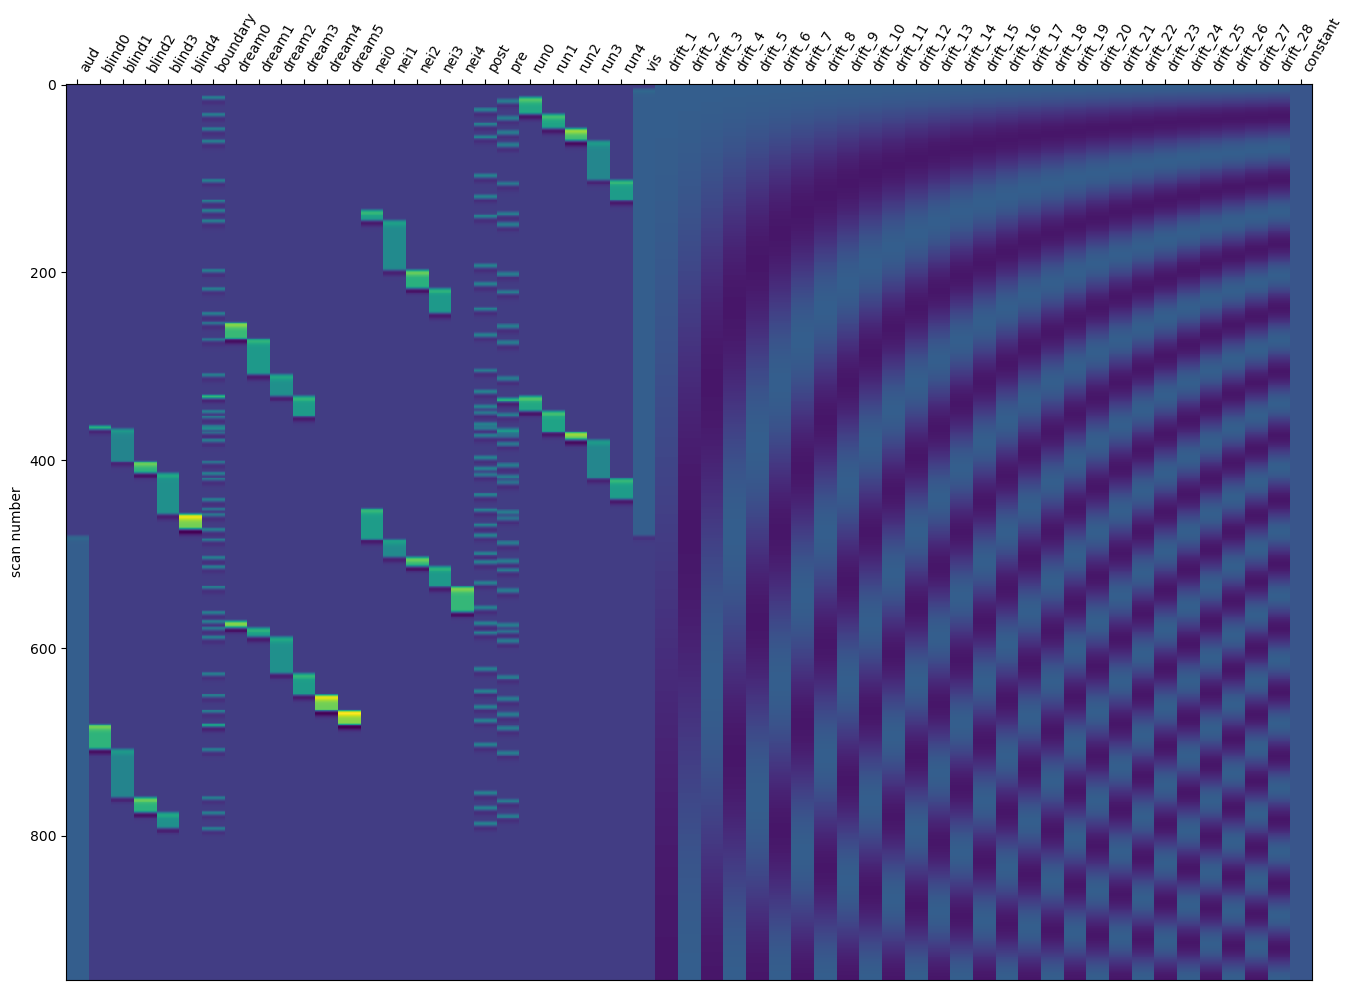

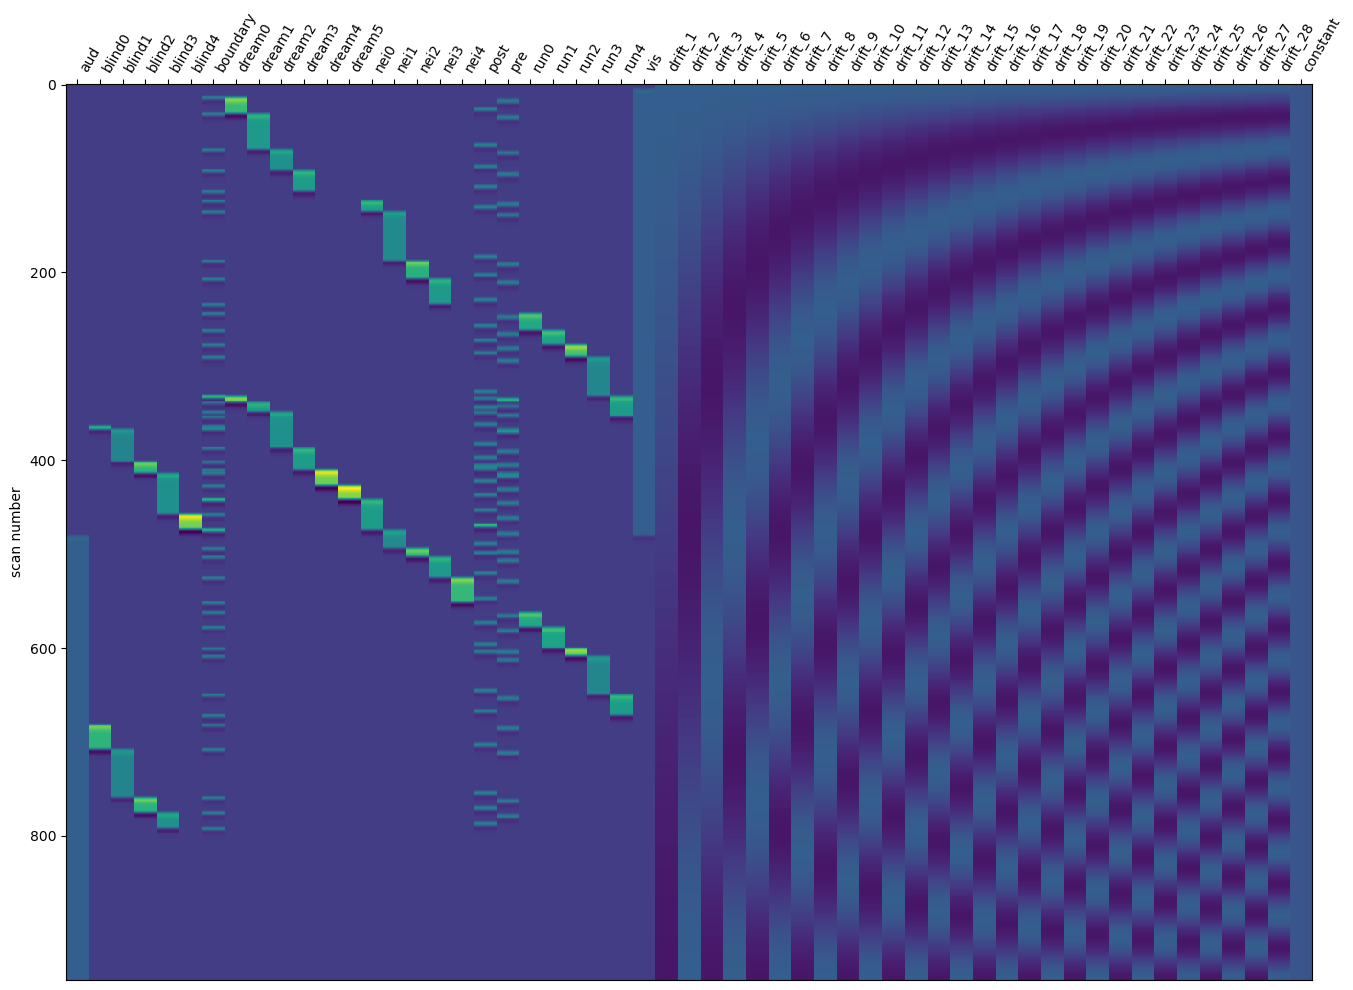

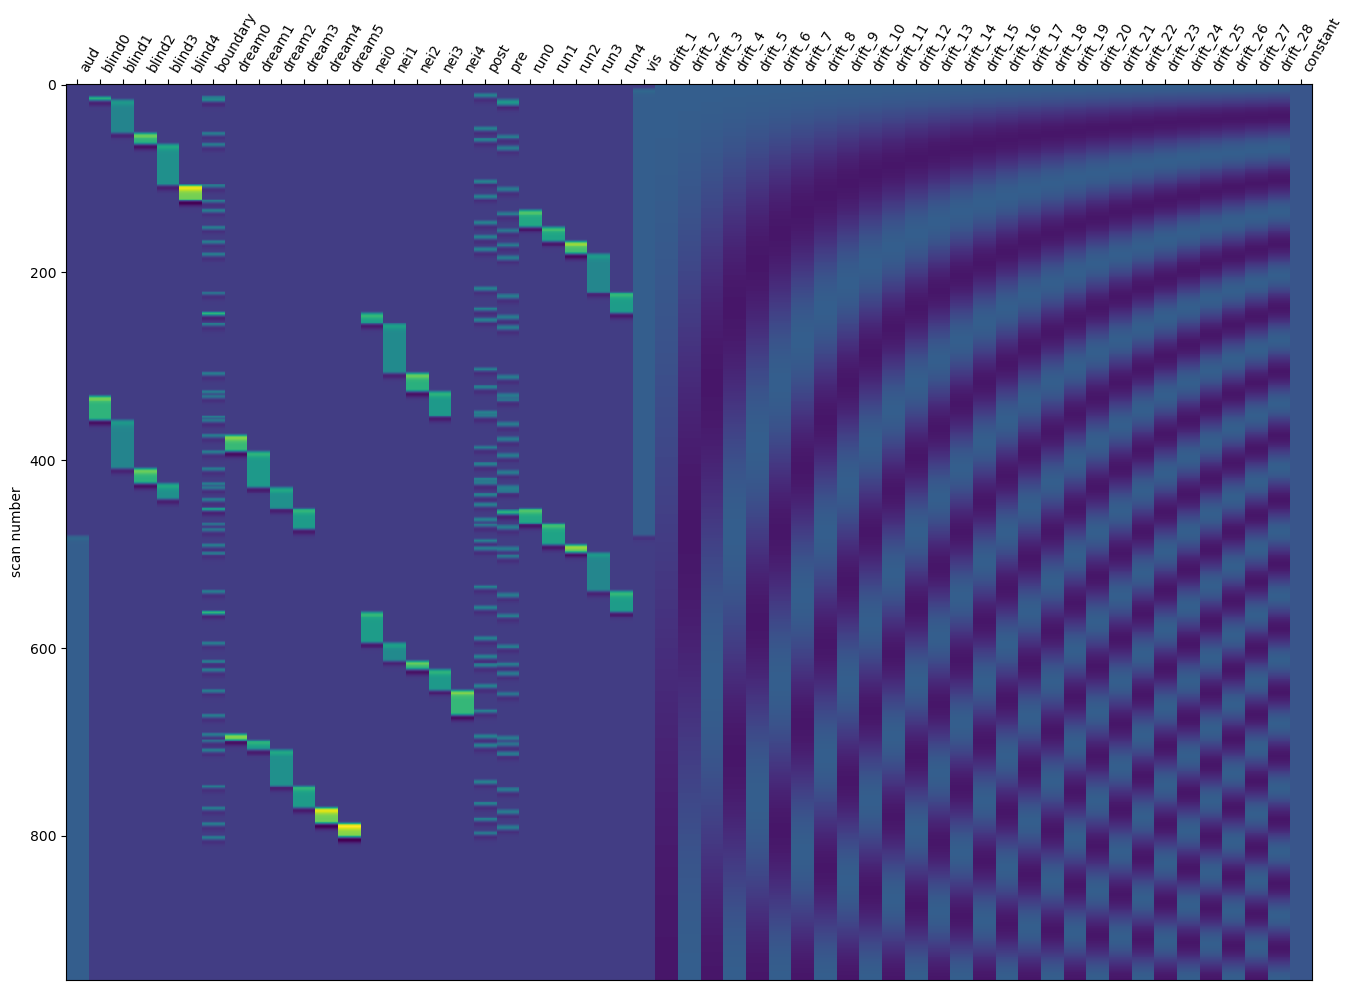

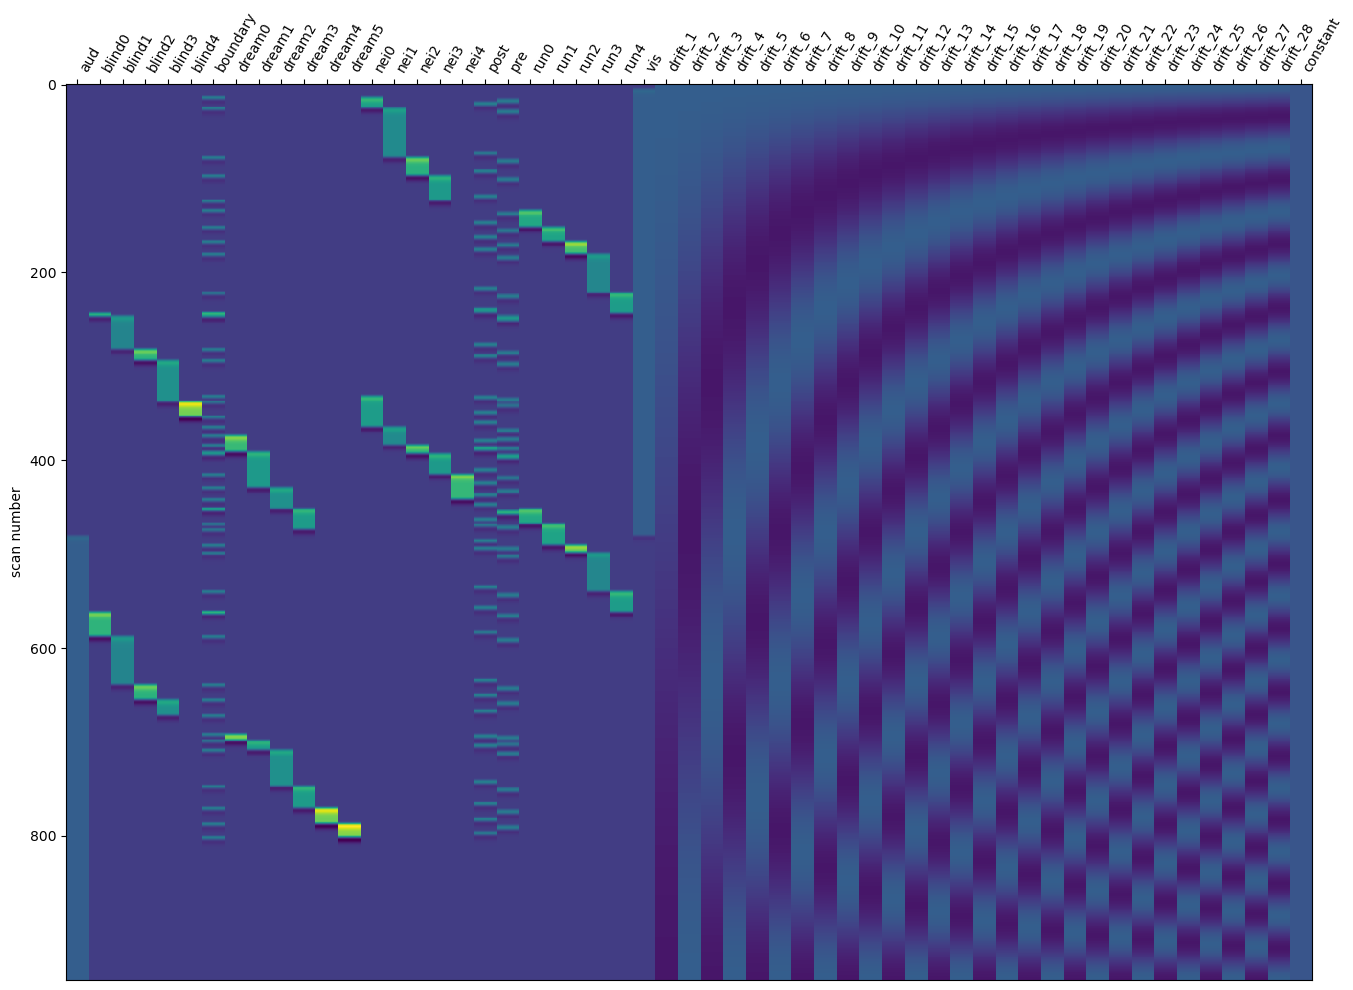

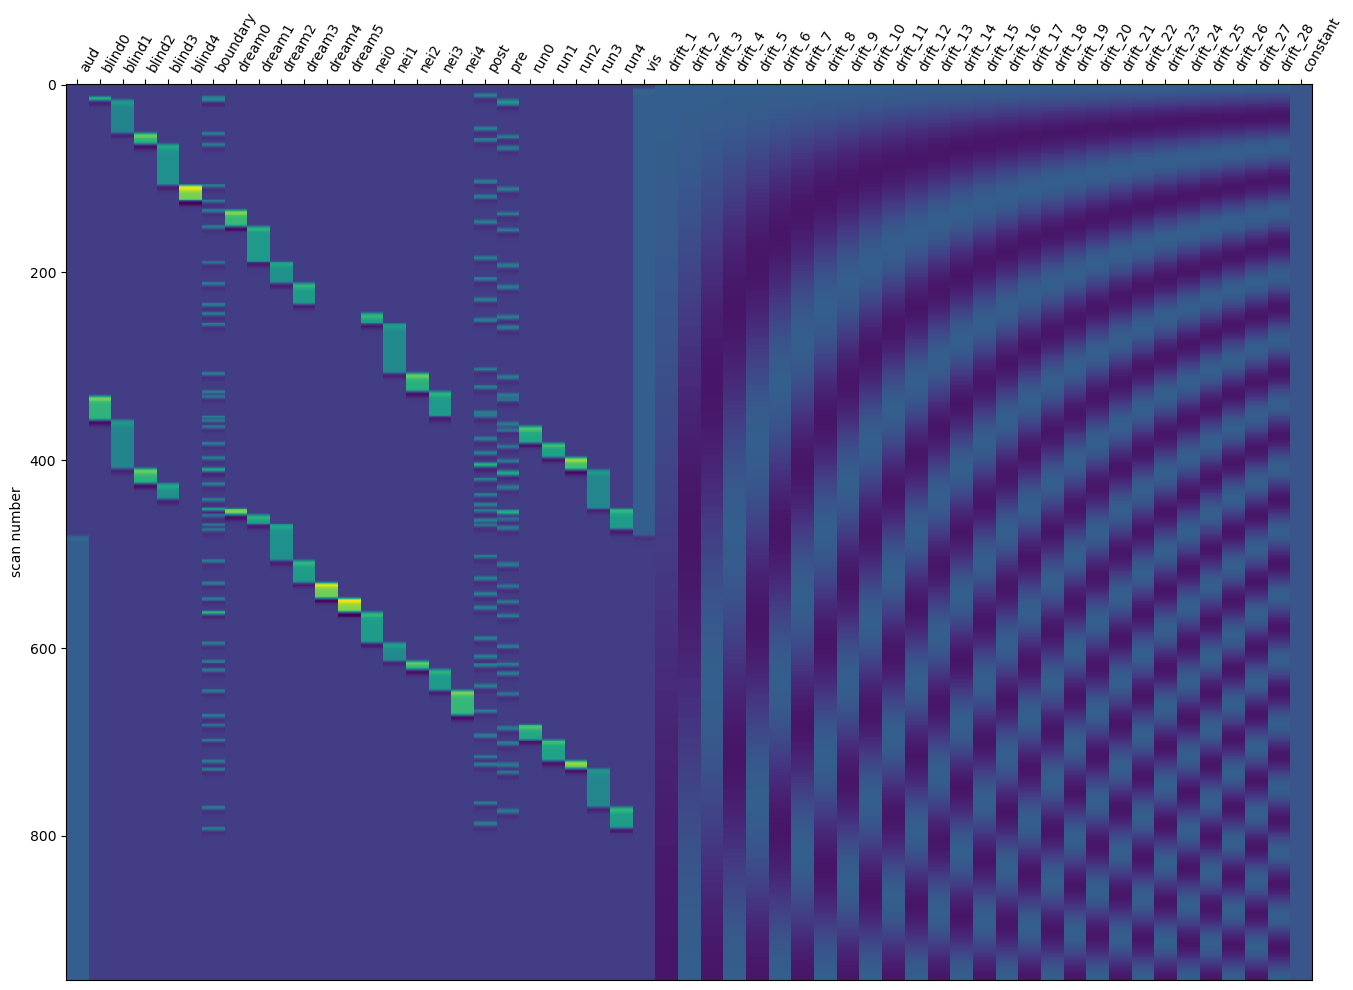

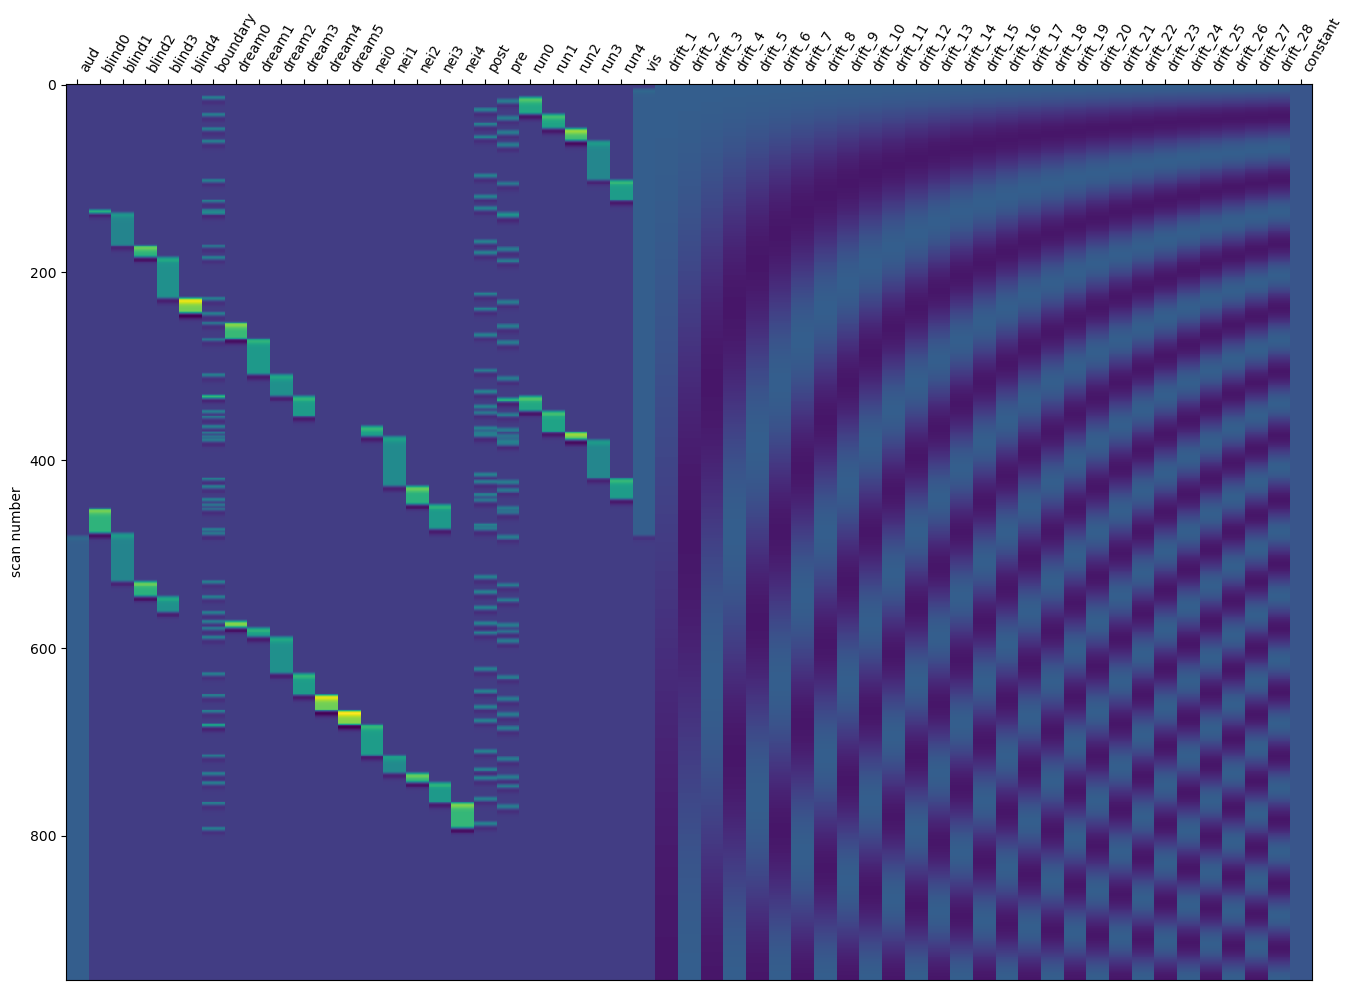

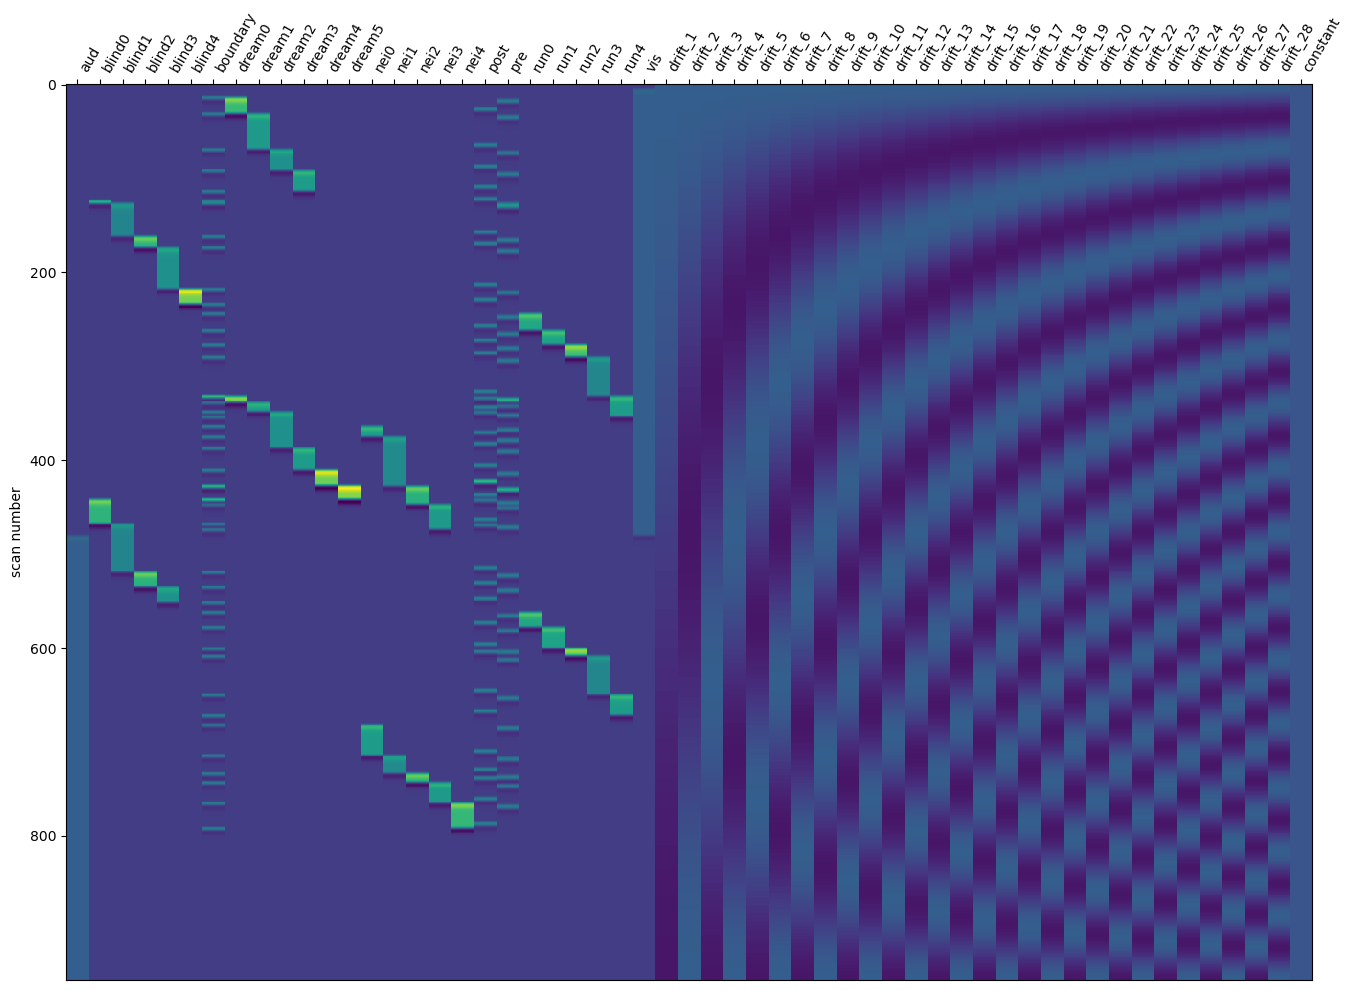

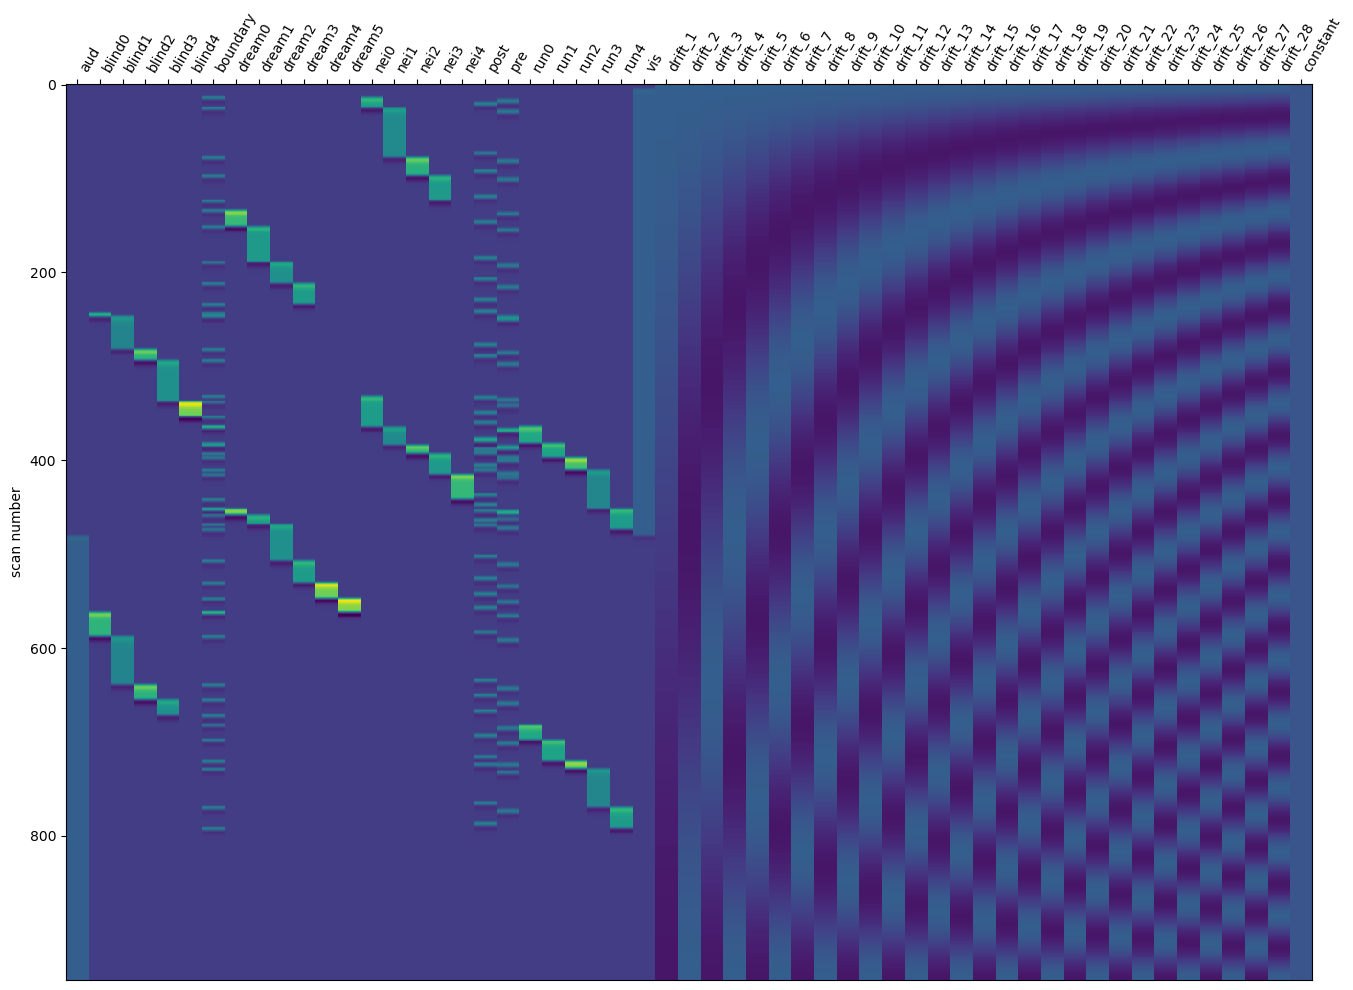

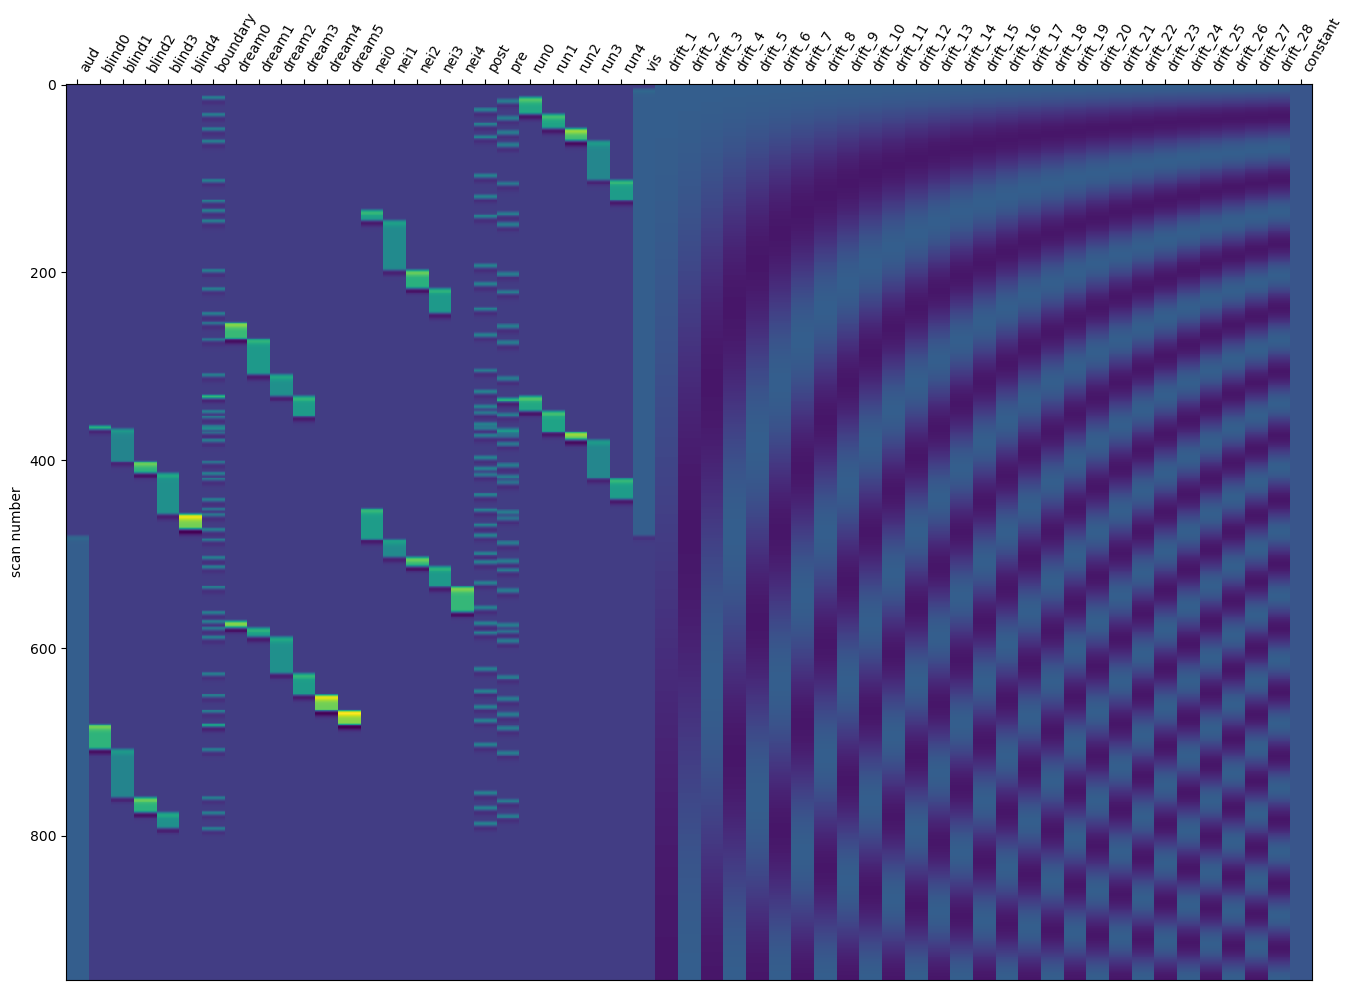

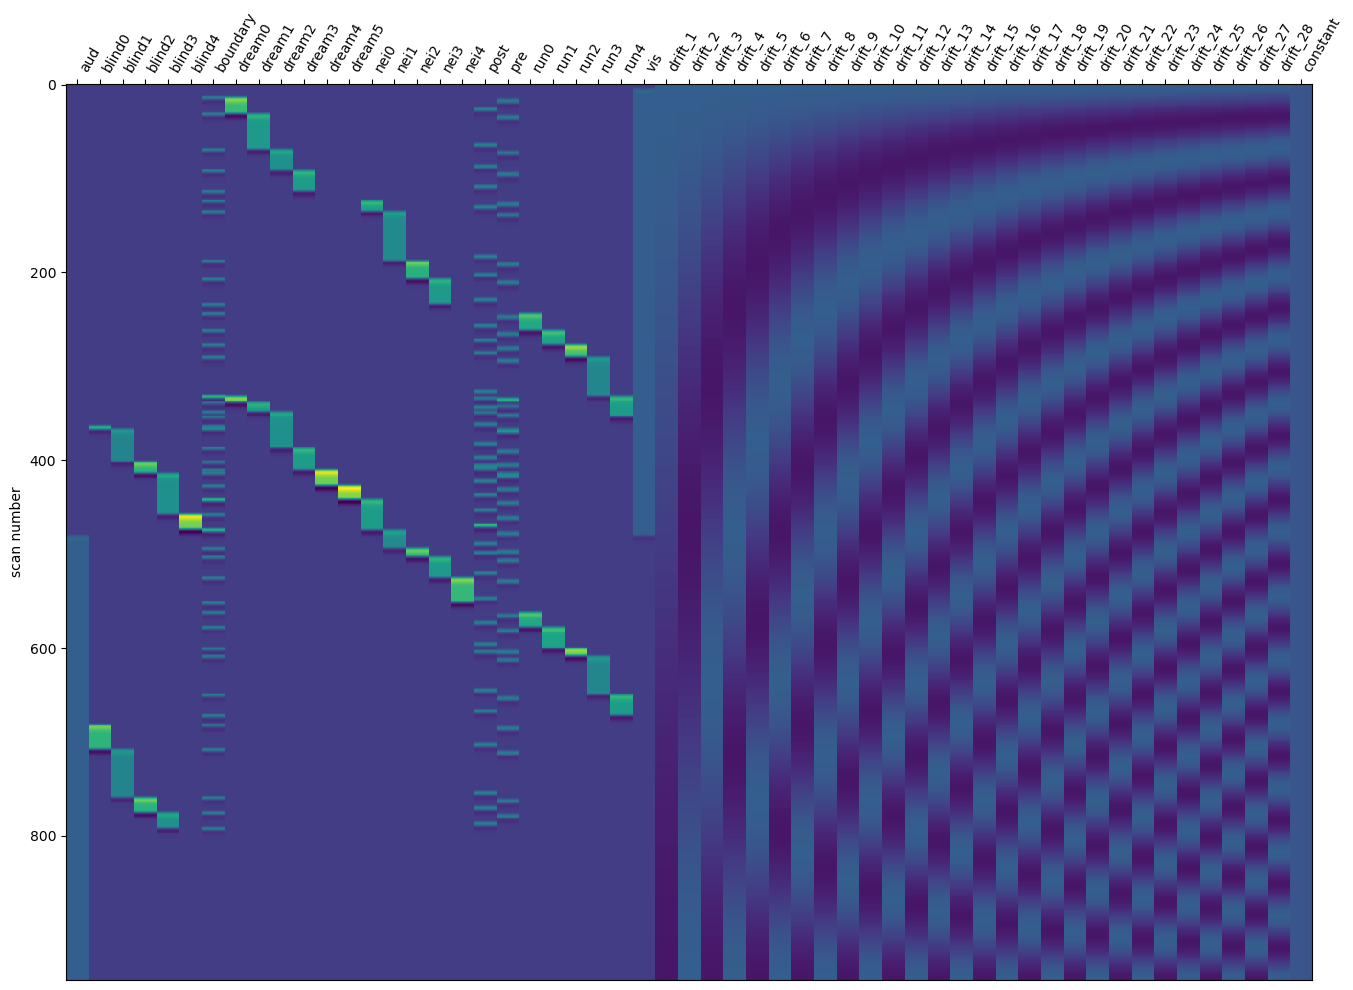

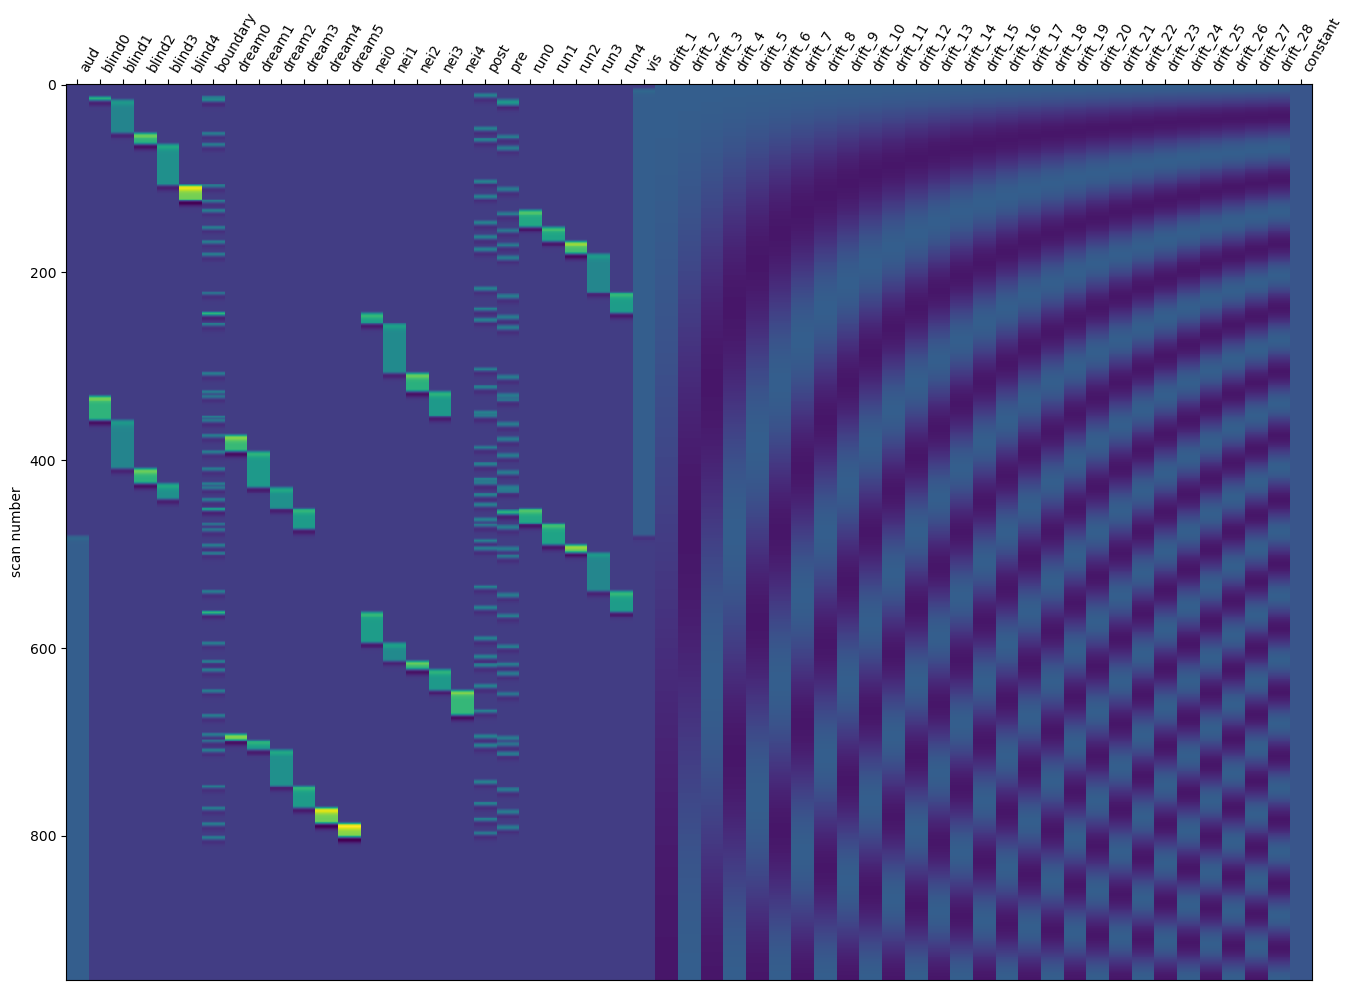

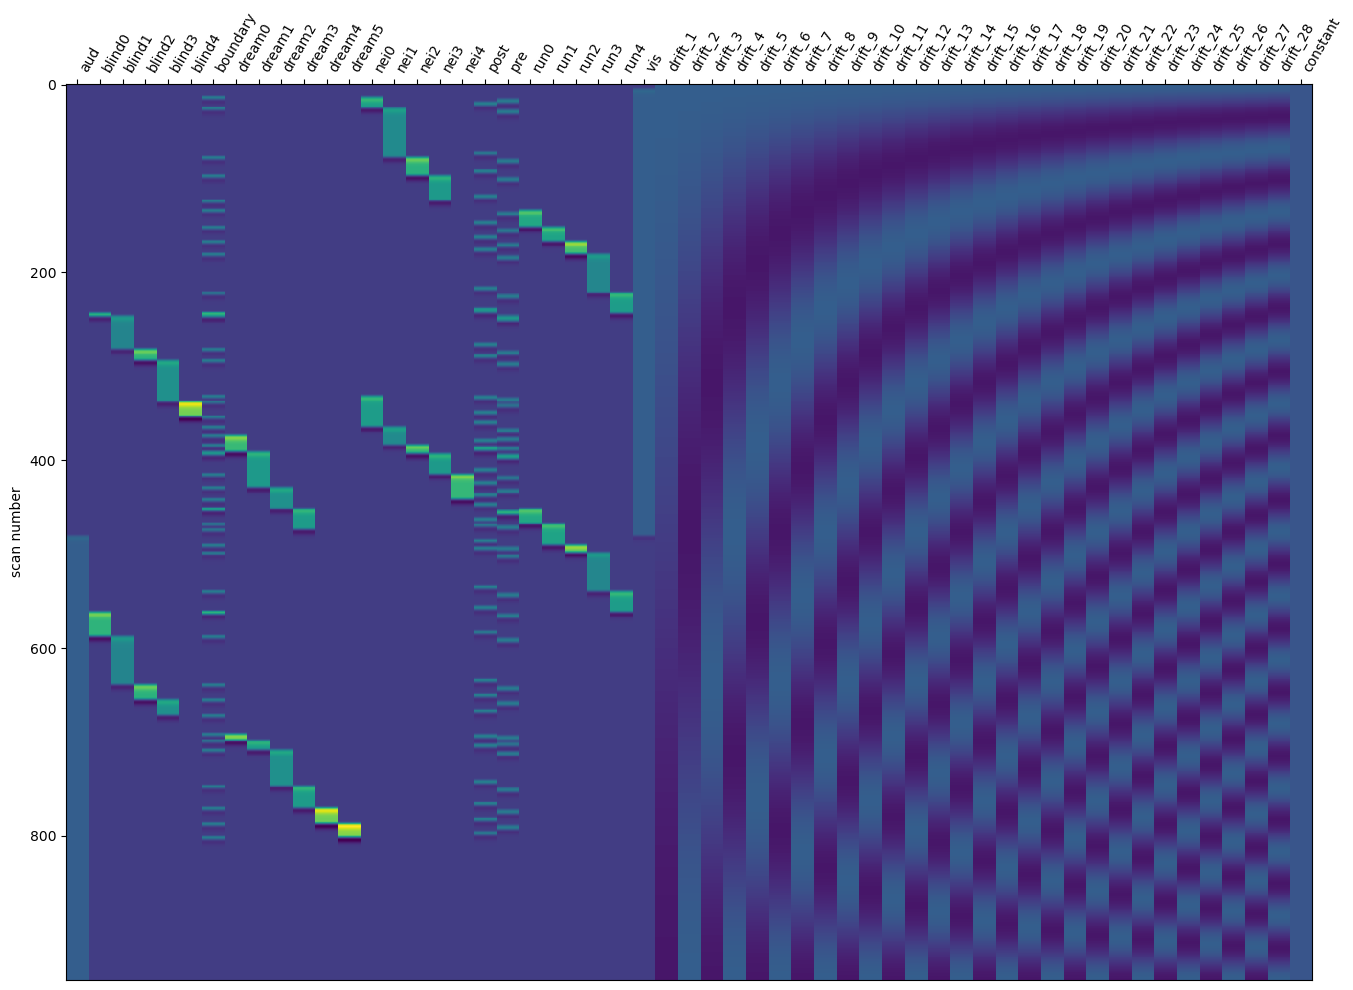

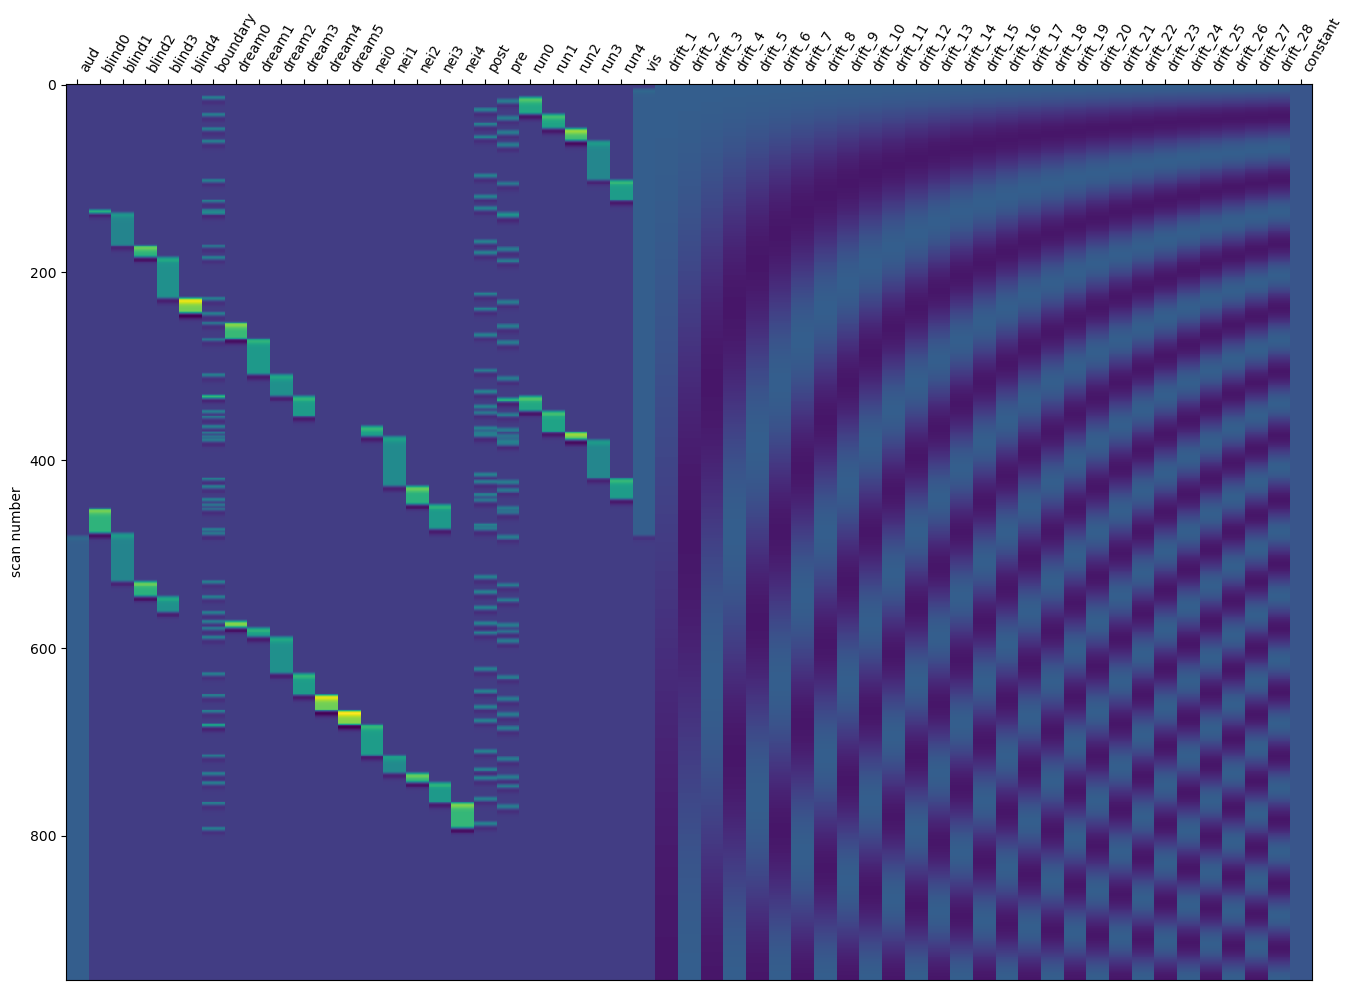

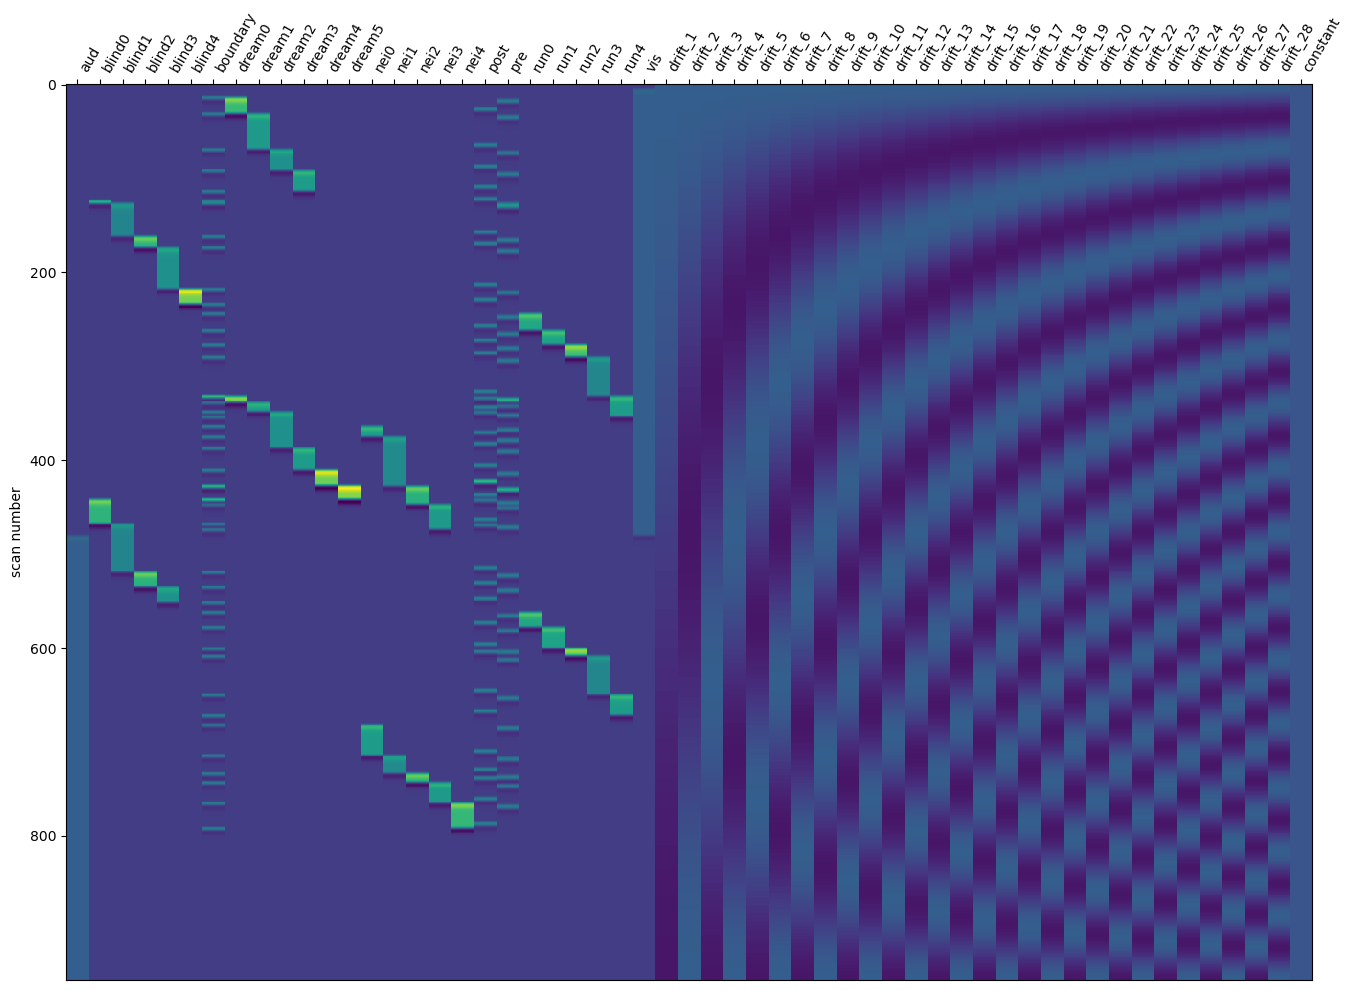

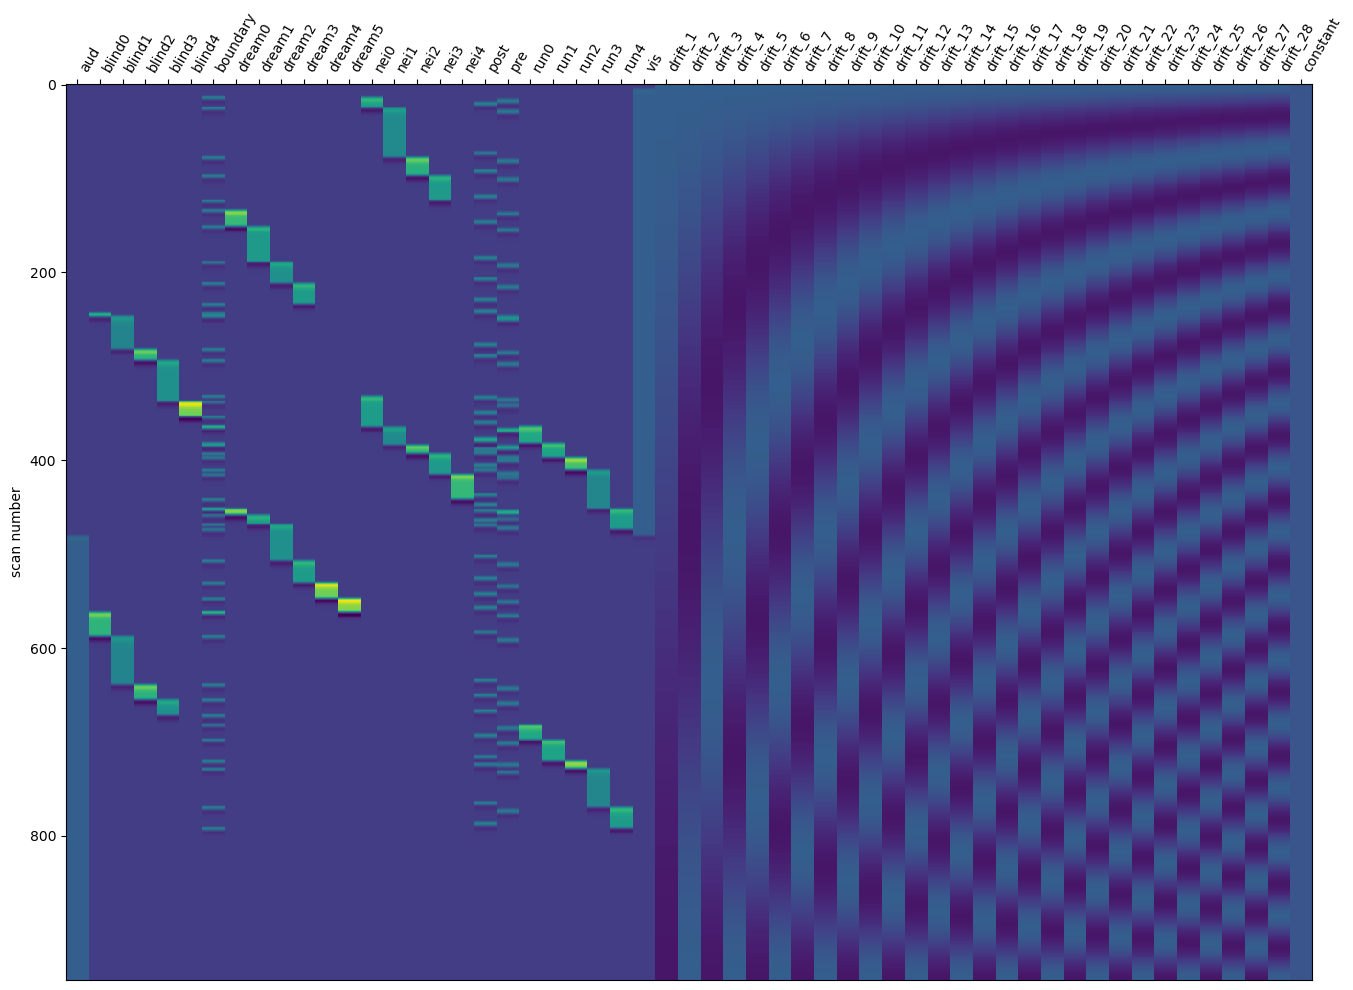

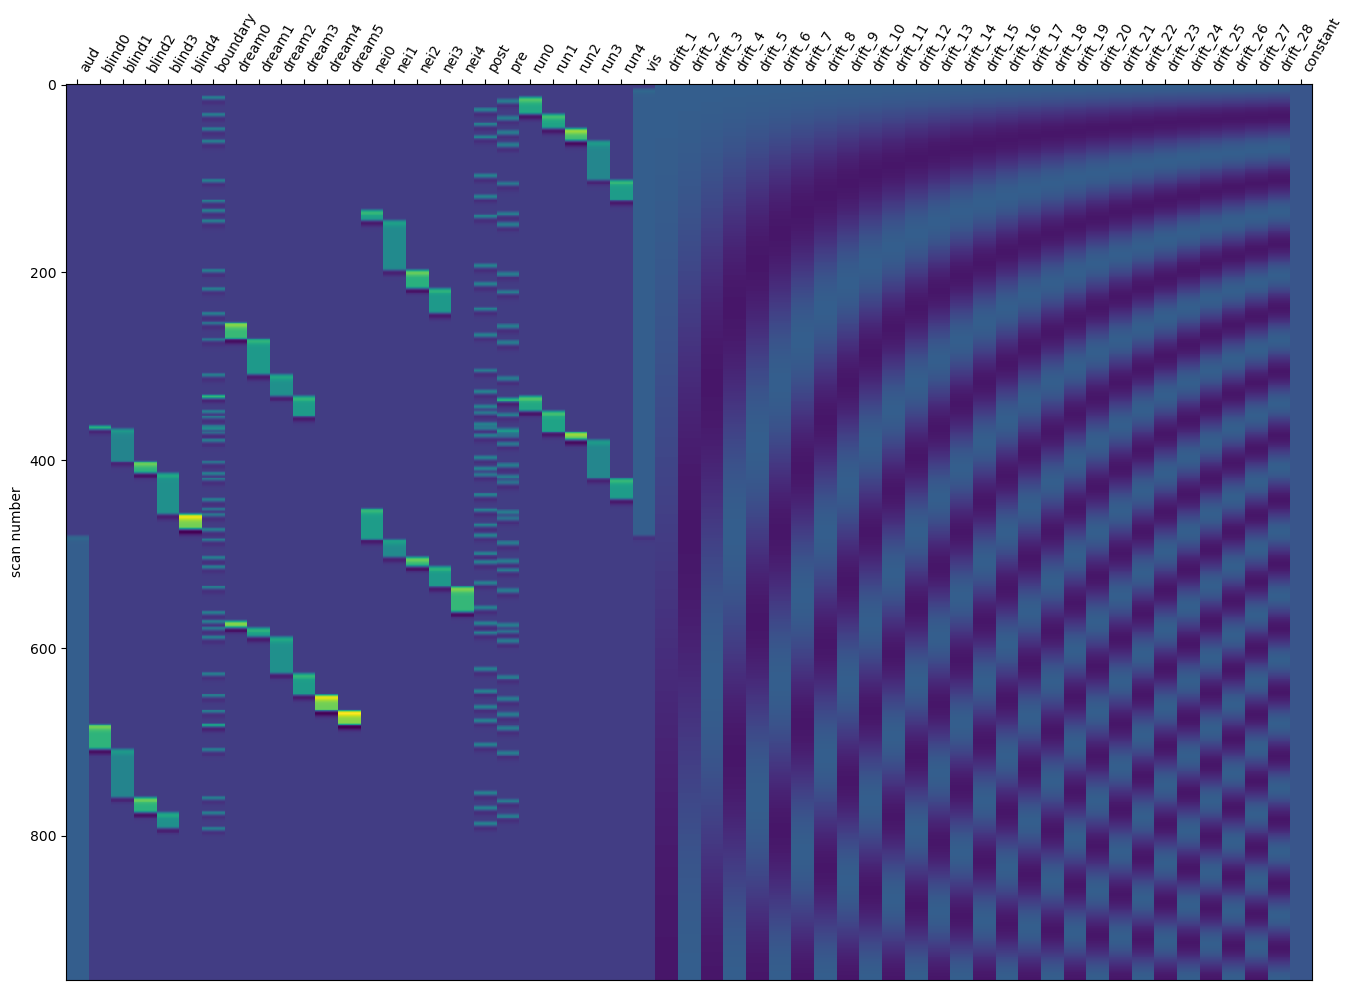

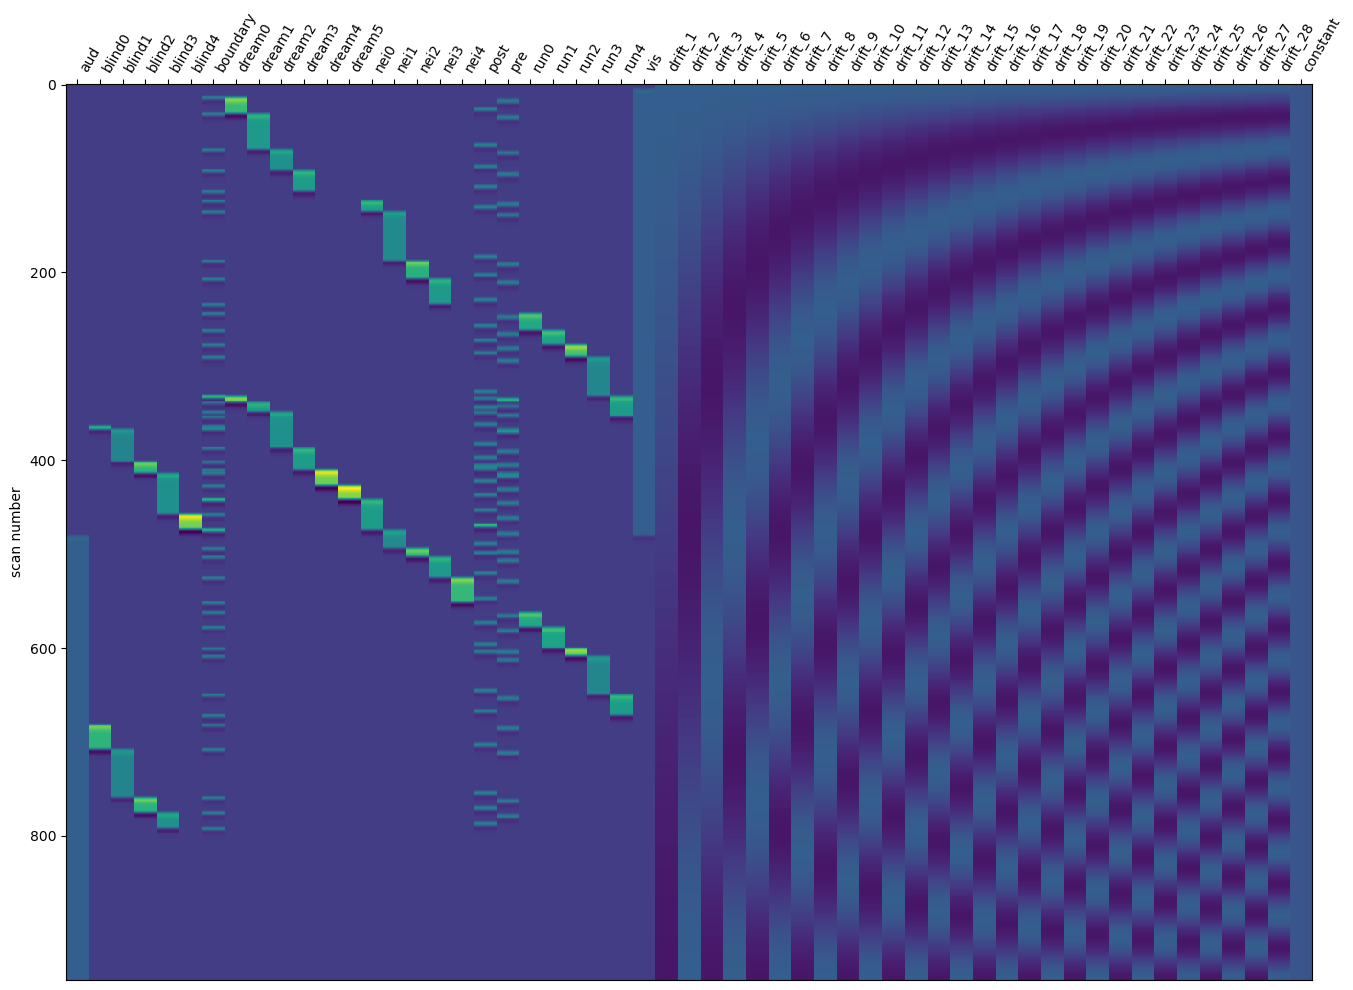

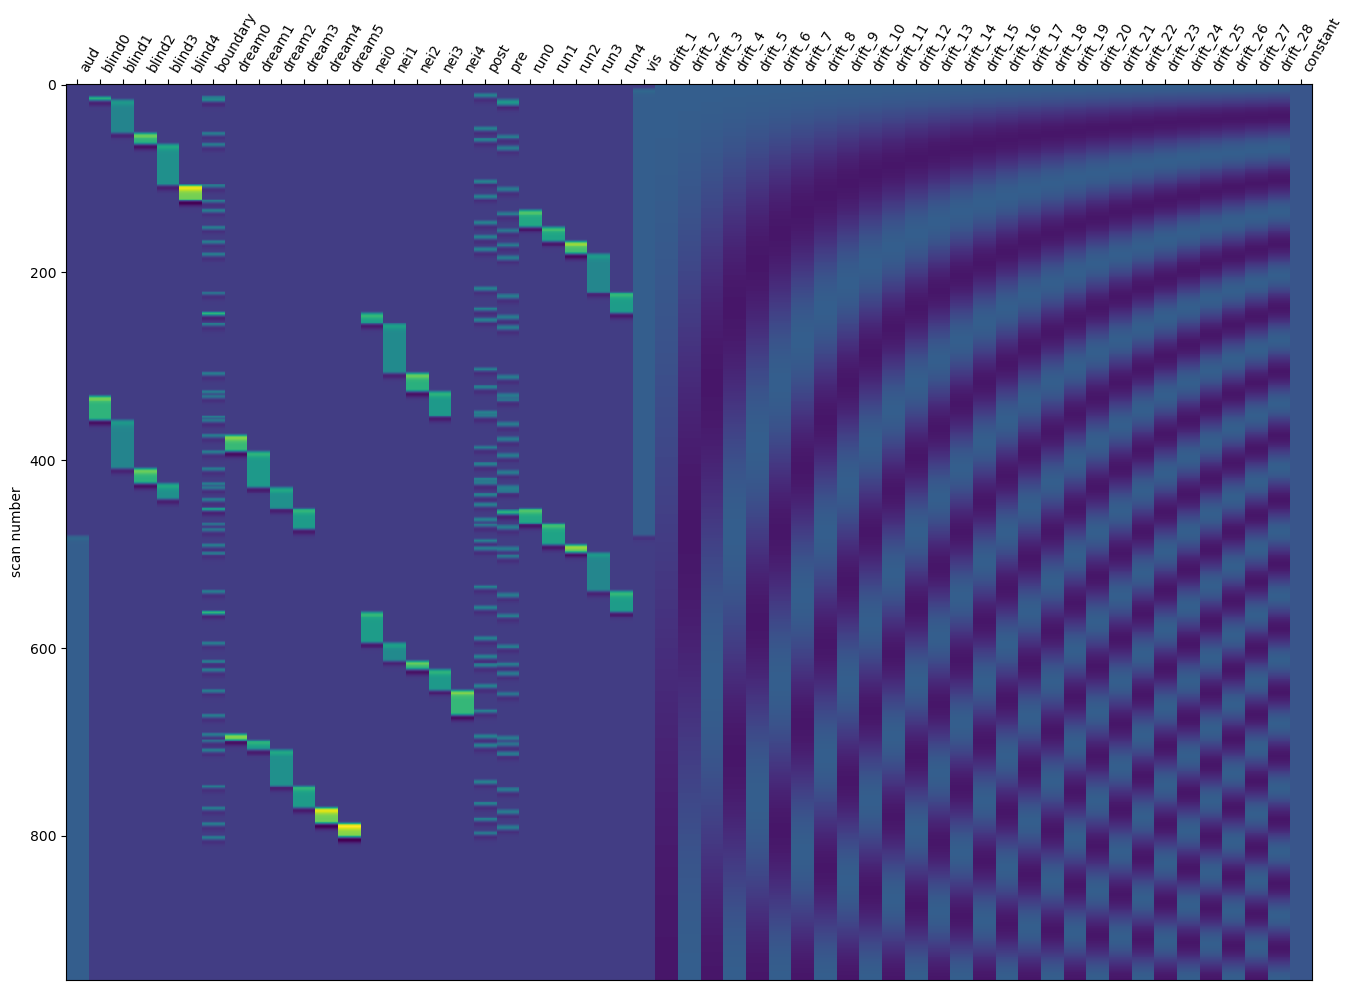

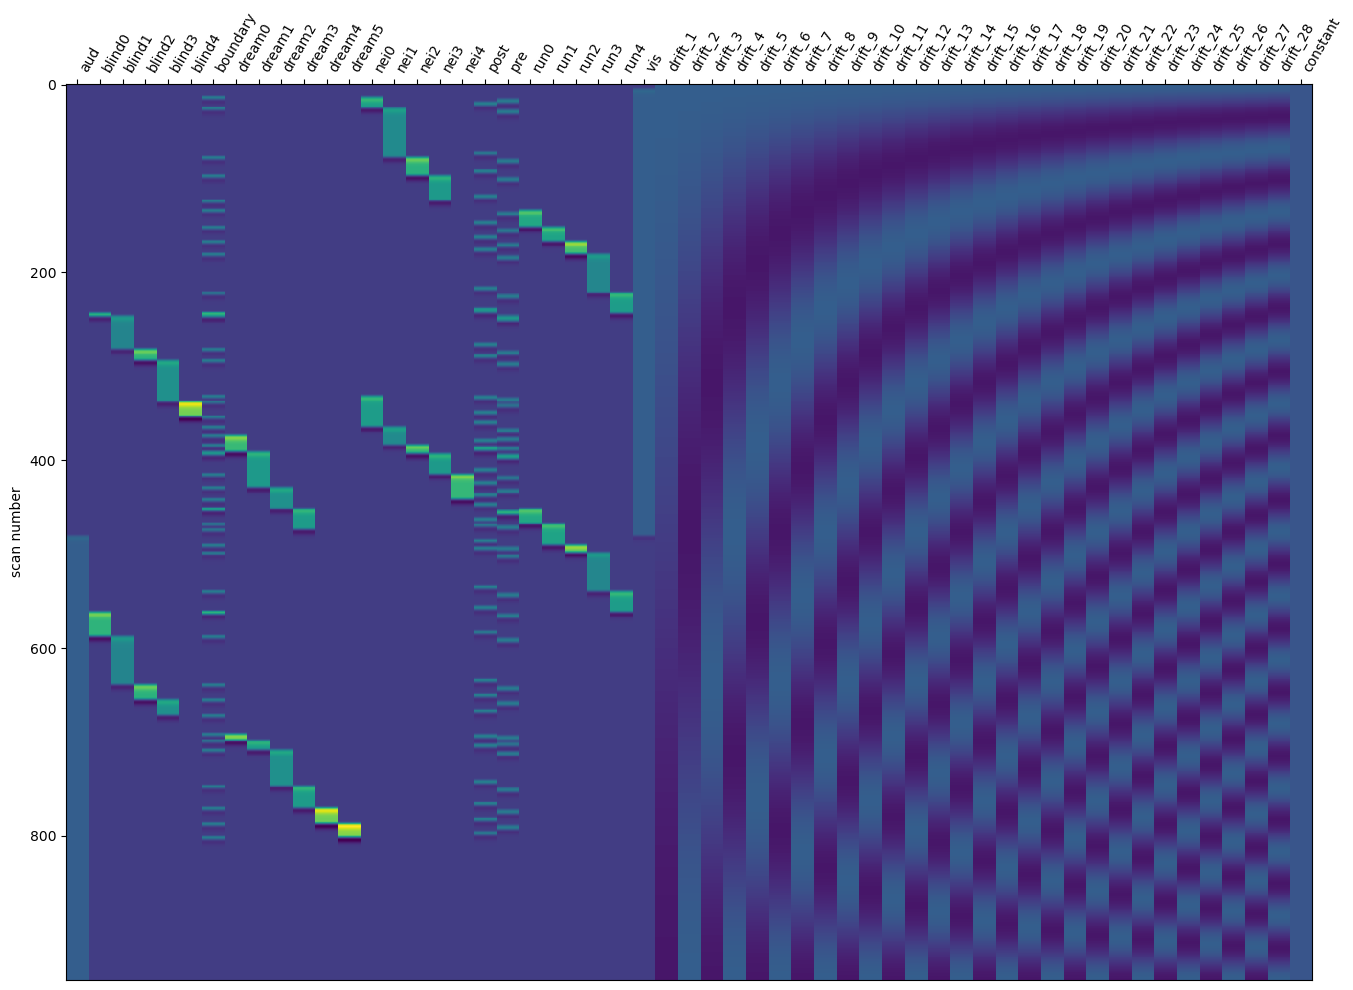

In [32]:
# Data Load & Trimming 
event_types = ['boundary','pre', 'post',  
               'blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0', 'dream1', 'dream2', 'dream3', 'dream4', 'dream5', 
               'nei0', 'nei1', 'nei2', 'nei3', 'nei4',  'run0', 'run1', 'run2','run3', 'run4', 
               'aud','vis'] 

# sequence = np.where(all_story[sub]=='Dream')[0][0]
# cond = 'Dream'+str(int(sequence)+1)

isi = 15  # Inter-stimulus interval between events in seconds
tr = 1.5  # Repetition time in seconds
dummy = 9 

#load BOLD Volume
for sub in subjects: 
#for sub in subjects: 

    print(sub)
    events = pd.DataFrame(sub_dm[sub])
    
    # Calculate the total number of scans
    #total_time = events['onset'].iloc[-1] +  events['duration'].iloc[-1] + dummy  # Time after last event ends
    n_scans = 954
    frame_times = np.arange(0, n_scans * tr, tr) # Frame times: time for each scan
    
    # Build a design matrix 
    design_matrix = make_first_level_design_matrix(frame_times,events,drift_model='cosine')
    print('event_size' , events.shape)
    print('desingMatrix_size', design_matrix.shape)

    # Plot the design matrix
    plot_design_matrix(design_matrix)
    # plot_path = os.path.join(May_dir, 'analysis', 'designMatirx', f"sub-{sub}_task-encoding_designMatrix.png")
    # plt.savefig(plot_path)

    #========================================================================================================
    encoding_file = glob.glob(os.path.join(May_dir,'denoised', 'denoised_2024', f"sub-{sub}_task-encoding_concatenated.nii.gz"))
    
    # Load fmri imgs for Fitting     
    print(f'Load concatenated func_img files')
    func_img = image.load_img(encoding_file) 
    print('Image shape:', func_img.shape)
       
    output_dir = os.path.join(May_dir,'analysis', 'betas_0621') 
    glm = FirstLevelModel(t_r=1.5, hrf_model='glover', drift_model='cosine')
    glm = glm.fit(func_img, design_matrices=design_matrix)
    
    beta_map = [glm.compute_contrast(event) for event in event_types]
    combined_4d_beta_img = nib.concat_images(beta_map)
    beta_img_path = os.path.join(output_dir, f"sub-{sub}_task-encoding_betas_image.nii.gz")
    nib.save(combined_4d_beta_img, beta_img_path)
    
    
    for event in ['boundary', 'pre','post']: 
        beta = glm.compute_contrast(event)
        beta_img_path = os.path.join(output_dir, f"sub-{sub}_task-encoding_betas_{event}_image.nii.gz")
        nib.save(beta, beta_img_path)

In [ ]:
# Data Load & Trimming 
onset = {'Dream1': [0, 165, 345, 525], 'Dream2': [0, 180, 345, 525], 'Dream3': [0, 180, 360, 525], 'Dream4': [0, 180, 345, 540]}
storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

# sequence = np.where(all_story[sub]=='Dream')[0][0]
# cond = 'Dream'+str(int(sequence)+1)

isi = 15  # Inter-stimulus interval between events in seconds
tr = 1.5  # Repetition time in seconds
dummy = 9 

#load BOLD Volume
for sub in subjects: 
    print(sub)
    
#     # Generate the events data frame
#     sequence = np.where(all_story[sub]=='Dream')[0][0]
#     cond = 'Dream'+str(int(sequence)+1)
    
#     events_list = []
#     for story in np.arange(0,4):    
#         thisStory = storyName[all_story[sub][story]] 
#         duration = [ai - bi for ai, bi in zip(eb_offset[thisStory], eb_onset[thisStory])]

#         for event in range(len(eb_onset[thisStory])):
#             events_list.append({
#                 'onset': onset[cond][story] + eb_onset[thisStory][event],
#                 'duration': duration[event],
#                 'trial_type': f'{thisStory}{event}'
#             })
    events = pd.DataFrame(sub_dm[sub])
    
    # Calculate the total number of scans
    total_time = events['onset'].iloc[-1] +  events['duration'].iloc[-1] + dummy  # Time after last event ends
    n_scans = int(total_time / tr)+1
    frame_times = np.arange(0, n_scans * tr, tr) # Frame times: time for each scan
    
    # Build a design matrix 
    design_matrix = make_first_level_design_matrix(frame_times,events,drift_model='cosine')
    print('event_size' , events.shape)
    print('desingMatrix_size', design_matrix.shape)

    # Plot the design matrix
    plot_design_matrix(design_matrix)
    plot_path = os.path.join(May_dir, 'analysis', 'designMatirx', f"sub-{sub}_task-encoding_designMatrix.png")
    plt.savefig(plot_path)

    #========================================================================================================
    encoding_file = glob.glob(os.path.join(May_dir,'denoised', 'denoised_2024', f"sub-{sub}_task-encoding_concatenated.nii.gz"))
    
    # Load fmri imgs for Fitting     
    print(f'Load concatenated func_img files')
    func_img = image.load_img(encoding_file) 
    print('Image shape:', func_img.shape)
       
    output_dir = os.path.join(May_dir,'analysis', 'betas_0621') 
    for i in range(0,2):
        glm = FirstLevelModel(t_r=1.5, hrf_model='glover', drift_model='cosine')
        glm = glm.fit(func_img, design_matrices=design_matrix)
        
        beta_map = [glm.compute_contrast(event) for event in events_type]

        # Compute and visualize beta maps
        #for j, label in enumerate(np.unique(events['trial_type'])):
            # Assuming `betas` is a list of 4D beta maps, one for each event
            #beta_map = glm.compute_contrast(label)
            #all_beta_imgs.append(beta_map)
            
            #plotting.plot_stat_map(beta_map, title=label, display_mode='z', threshold=2.3, cut_coords=5)
        combined_4d_beta_img = nib.concat_images(beta_map)
        beta_img_path = os.path.join(output_dir, f"sub-{sub}_task-encoding_run-0{i+1}_betas_image.nii.gz")
        nib.save(combined_4d_beta_img, beta_img_path)

## Visualization beta maps

In [15]:
from nltools.data import Brain_Data

sub = 2 
beta_file = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-{sub}_task-encoding_betas_image.nii.gz"))
beta = Brain_Data(beta_file)
print(beta.shape)

<bound method Brain_Data.shape of nltools.data.brain_data.Brain_Data(data=(26, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)>


In [13]:
from nltools.data import Brain_Data
t_stat_imgs = {}
for event in ['boundary', 'pre','post']: 
    con1_file_list = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))
    con1_dat = Brain_Data(con1_file_list)
    con1_stats = con1_dat.ttest()
    #t_stat_img = con1_stats['t'].to_nifti()
    t_stat_imgs[event] =con1_stats['t']

    #output_dir = os.path.join(May_dir,'analysis', 'GLM0624') 
    #beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_{event}_image.nii.gz")
    #nib.save(t_stat_img, beta_img_path)

In [17]:
t_stat_imgs['pre'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

# 2. Recall_detail score 

### Event models for recall data 

In [4]:
# Load recall data 
import numpy as np
import json
import csv
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

overall_performance_dir = "/mnt/c/Users/since/Dropbox/RAs/projects"


# #Subject check 
# sub_sm = np.arange(1,34)
# sub_sm_exclude = [8, 25] #exclude 9 & 26
# subjects = np.delete(sub_sm, sub_sm_exclude)


# # Set columns 
# sub_idx, vis, aud = [], [], []
# for sub in subjects:
    
#     if sub < 10:
#         vis_idx = 'V0'+str(sub)
#         aud_idx = 'A0'+str(sub)
#     else:
#         vis_idx = 'V'+str(sub)
#         aud_idx = 'A'+str(sub) 
#     sub_idx.append(vis_idx)
#     sub_idx.append(aud_idx)
#     vis.append(vis_idx)
#     aud.append(aud_idx)

In [5]:
#Subject check 
sub_sm = np.arange(1,34)
sub_sm_exclude = [8, 25] #exclude 9 & 26
subjects = np.delete(sub_sm, sub_sm_exclude)


# Set columns 
sub_idx, vis, aud, subj = [], [], [], []
for sub in subjects:
    
    if sub < 10:
        aud_idx = 'A0'+str(sub)
        vis_idx = 'V0'+str(sub)
        subj_idx = 'S0'+str(sub)
    else:
        aud_idx = 'A'+str(sub)
        vis_idx = 'V'+str(sub)
        subj_idx = 'S'+str(sub)
        
    sub_idx.append(vis_idx)
    sub_idx.append(aud_idx)
    vis.append(vis_idx)
    aud.append(aud_idx)
    subj.append(subj_idx)
    #aud.append(aud_idx)
    
sub_sm2 = np.arange(34,77)
#print(sub_sm2)
sub_sm_exclude2 = [2, 3, 7, 13, 22, 23, 26, 27,28,29,35] #Excluede 36, 37, 41, 47, 56, 57, 60, 61,62,63,69
subjects2 = np.delete(sub_sm2, sub_sm_exclude2)
#print(subjects2)

# Set columns 
sub_idx2, vis2, aud2, subj2 = [], [], [], []
for sub in subjects2:
    
    if sub < 10:
        aud_idx = 'A0'+str(sub)
        vis_idx = 'V0'+str(sub)
        subj_idx = 'S0'+str(sub)
    else:
        aud_idx = 'A'+str(sub)
        vis_idx = 'V'+str(sub)
        subj_idx = 'S'+str(sub)
        
    sub_idx2.append(vis_idx)
    sub_idx2.append(aud_idx)
    vis2.append(vis_idx)
    aud2.append(aud_idx)
    subj2.append(subj_idx)
print(subj)

['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33']


In [6]:
#Load files 
rating_files = "Ratings/2.EventRating"
fpath = os.path.join(overall_performance_dir, 'KiKang' ,rating_files)
fname1 = 'Event_counting_KK1' +'.xlsx'

#sub-01~33
use_cols1 = np.arange(3,65)
use_cols2 = np.arange(3,67)

run = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'RunningMan',usecols = use_cols1, names = sub_idx)[0:13]
run2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'RunningMan2',usecols = use_cols1, names = sub_idx)[0:13]

nei = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Neigobors',usecols = use_cols1, names = sub_idx)[0:13]
nei2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Neighbors2',usecols = use_cols1, names = sub_idx)[0:13]

dre = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Dream',usecols = use_cols1, names = sub_idx)[0:12]
dre2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Dream2',usecols = use_cols1, names = sub_idx)[0:12]

bli = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'BlindDate',usecols = use_cols1, names = sub_idx)[0:13]
bli2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'BlindDate2',usecols = use_cols1, names = sub_idx)[0:13]

#df NAN to Zero 
dre = dre.fillna(0)
dre2 = dre2.fillna(0)

overall1 = {'run' : run, 'nei':nei, 'dream': dre, 'blind':bli} # First encoding 
overall2 = {'run' : run2, 'nei':nei2, 'dream': dre2, 'blind':bli2} #Second Encoding

In [6]:
#Load files 
rating_files = "Ratings/2.EventRating"
fpath = os.path.join(overall_performance_dir, 'KiKang' ,rating_files)
print(fpath)
fname1 = 'Event_counting_KK1' +'.xlsx'
fname2 = 'Event_counting_KK2' +'.xlsx'


#sub-01~33
use_cols1 = np.arange(3,65)
use_cols2 = np.arange(3,67)

run = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'RunningMan',usecols = use_cols1, names = sub_idx)[0:13]
run2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'RunningMan2',usecols = use_cols1, names = sub_idx)[0:13]
run3 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'RunningMan',usecols = use_cols2, names = sub_idx2)[0:13]
run4 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'RunningMan2',usecols = use_cols2, names = sub_idx2)[0:13]

nei = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Neigobors',usecols = use_cols1, names = sub_idx)[0:13]
nei2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Neighbors2',usecols = use_cols1, names = sub_idx)[0:13]
nei3 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'Neigobors',usecols = use_cols2, names = sub_idx2)[0:13]
nei4 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'Neighbors2',usecols = use_cols2, names = sub_idx2)[0:13]

dre = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Dream',usecols = use_cols1, names = sub_idx)[0:12]
dre2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'Dream2',usecols = use_cols1, names = sub_idx)[0:12]
dre3 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'Dream',usecols = use_cols2, names = sub_idx2)[0:12]
dre4 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'Dream2',usecols = use_cols2, names = sub_idx2)[0:12]


bli = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'BlindDate',usecols = use_cols1, names = sub_idx)[0:13]
bli2 = pd.read_excel(os.path.join(fpath, fname1), sheet_name = 'BlindDate2',usecols = use_cols1, names = sub_idx)[0:13]
bli3 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'BlindDate',usecols = use_cols2, names = sub_idx2)[0:13]
bli4 = pd.read_excel(os.path.join(fpath, fname2), sheet_name = 'BlindDate2',usecols = use_cols2, names = sub_idx2)[0:13]


#df NAN to Zero 
nei3 = nei3.fillna(0)
dre = dre.fillna(0)
dre2 = dre2.fillna(0)
dre3 = dre3.fillna(0)
dre4 = dre4.fillna(0)
bli3 = bli3.fillna(0)
bli4 = bli4.fillna(0)

overall1 = {'run' : run, 'nei':nei, 'dream': dre, 'blind':bli}
overall2 = {'run' : run2, 'nei':nei2, 'dream': dre2, 'blind':bli2}
overall3 = {'run' : run3, 'nei':nei3, 'dream': dre3, 'blind':bli3}
overall4 = {'run' : run4, 'nei':nei4, 'dream': dre4, 'blind':bli4}

/mnt/c/Users/since/Dropbox/RAs/projects/KiKang/Ratings/2.EventRating


In [7]:
# Fidelity Score for each subject 

story_onset =  {'run' : [15, 24,36,39,48,63,72,84,96,129,144,162,168], 'nei': [15,24,33,39,51,63,78,90,108,129,141,156,171], 
                'dream': [15, 27,39,45,63,75,87,102,114,129,144,159] , 'blind': [ 15, 30, 42, 54, 63, 75, 87, 111, 120, 132, 138, 156, 174] }
story_offset =  {'run' : [23,35,38,47,62,71,83,95,128,143,161,167,180], 'nei': [23,32,39,50,62,77,89,107,128,140,155,170,180], 
                 'dream': [26, 38, 44, 62, 74, 86, 101, 113, 128, 143, 158, 165] , 'blind': [29, 41, 53, 62, 74, 86, 110, 119, 131, 137, 155, 173, 180] }

storyName = {'RunningMan': 'run', 'BlindDate': 'blind', 'Dream':'dream', 'Neighbors':'nei'}

onset = {'Dream1': [0, 165, 345, 525], 'Dream2': [0, 180, 345, 525], 'Dream3': [0, 180, 360, 525], 'Dream4': [0, 180, 345, 540]}

In [8]:
subjects = [34, 70, 71, 72, 73, 74, 75]

sub_recall_dm = {} 
for sub in subjects:
    #print(sub)

    if sub < 10 : 
        vis_sub = 'V0'+str(sub)
        aud_sub = 'A0'+str(sub)
        encoding = {'first': overall1, 'second': overall2}
    else: 
        vis_sub = 'V'+str(sub)
        aud_sub = 'A'+str(sub)
        encoding = {'first': overall3, 'second': overall4}
    # Generate the events data frame
    sequence = np.where(all_story[sub]=='Dream')[0][0]
    story_sequence = 'Dream'+str(int(sequence)+1)

    
    timeline = {'first': 0, 'second': 715}
    # EB condition 

    scene_list = []
    for story in np.arange(0,4):    
        thisStory = storyName[all_story[sub][story]] 
        for cond in ['first','second']:

            for event in range(12):

                scene_list.append({
                    'onset': timeline[cond] + onset[story_sequence][story] + story_onset[thisStory][event],
                    'duration': story_offset[thisStory][event] - story_onset[thisStory][event],
                    'modulation' : encoding[cond][thisStory][vis_sub][event],
                    'trial_type': f'{cond}_vis'
                })
                
            for event in range(12): 
                scene_list.append({
                    'onset': timeline[cond] +  onset[story_sequence][story] + story_onset[thisStory][event],
                    'duration':story_offset[thisStory][event] - story_onset[thisStory][event],
                    'modulation' : encoding[cond][thisStory][aud_sub][event],
                    'trial_type': f'{cond}_aud'
                })

    # Convert to DataFrame
    scene_events = pd.DataFrame(scene_list)
    sub_recall_dm[sub] = scene_events
    
np.save('/home/sincerely/jupyterlab/3. Behav/VCNL/results/recall_performances.npy', sub_recall_dm)


### DM Fitting : Recall_detail score

75
A 'modulation' column was found in the given events data and is used.
event_size (192, 4)
desingMatrix_size (954, 33)
Load concatenated func_img files
Image shape: (91, 109, 91, 954)
finish GLM for 75


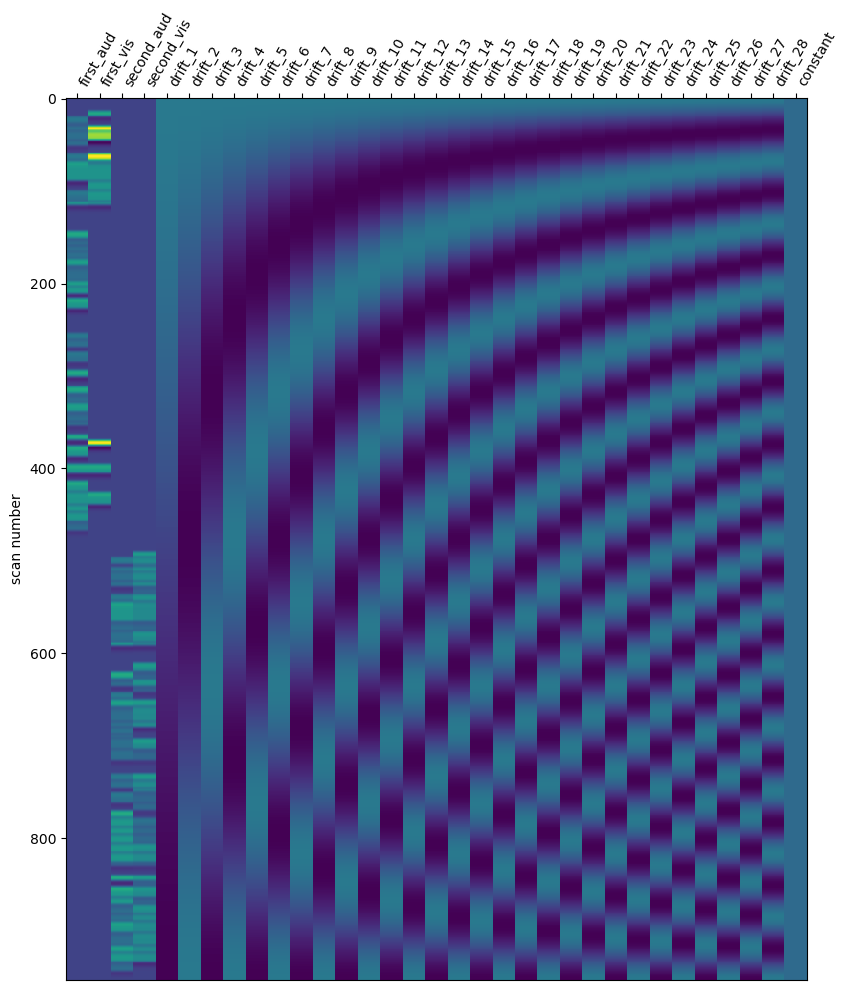

In [9]:
# Data Load & Trimming 
event_types = ['first_vis','first_aud', 'second_vis', 'second_aud'] 

# #Subject check 
# sub_sm = np.arange(1,34)
# sub_sm_exclude = [0, 8, 25] #exclude 9 & 26
# subjects = np.delete(sub_sm, sub_sm_exclude)
# #print(subject)
# print(subjects)
subjects = [75]

# sequence = np.where(all_story[sub]=='Dream')[0][0]
# cond = 'Dream'+str(int(sequence)+1)

#isi = 15  # Inter-stimulus interval between events in seconds
tr = 1.5  # Repetition time in seconds
dummy = 9 

# file_path = '/home/sincerely/jupyterlab/3. Behav/VCNL/results/recall_performances.npy'
# sub_recall_dm = np.load(file_path,  allow_pickle=True)


#load BOLD Volume
for sub in subjects: 
#for sub in subjects: 

    print(sub)
    events = pd.DataFrame(sub_recall_dm[sub])
    
    # Calculate the total number of scans
    #total_time = events['onset'].iloc[-1] +  events['duration'].iloc[-1] + dummy  # Time after last event ends
    n_scans = 954
    frame_times = np.arange(0, n_scans * tr, tr) # Frame times: time for each scan
    
    # Build a design matrix 
    design_matrix = make_first_level_design_matrix(frame_times,events,drift_model='cosine')
    print('event_size' , events.shape)
    print('desingMatrix_size', design_matrix.shape)

    # Plot the design matrix
    plot_design_matrix(design_matrix)
    plot_path = os.path.join(May_dir, 'GLM_July', 'designMatrix', f"sub-{sub}_task-encoding_designMatrix.png")
    plt.savefig(plot_path)

    #========================================================================================================
    #encoding_file = glob.glob(os.path.join(May_dir,'denoised', f"sub-{sub}_task-encoding_concatenated.nii.gz"))
    
    encoding_file = glob.glob(os.path.join(May_dir,'GLM_July','data', f"sub-{sub}_task-encoding_concatenated.nii.gz"))
    # Load fmri imgs for Fitting     
    print(f'Load concatenated func_img files')
    func_img = image.load_img(encoding_file) 
    print('Image shape:', func_img.shape)
       
    glm = FirstLevelModel(t_r=1.5, hrf_model='glover', drift_model='cosine')
    glm = glm.fit(func_img, design_matrices=design_matrix)
    
    for event in event_types: 
        beta = glm.compute_contrast(event)
        beta_img_path = os.path.join(May_dir,'GLM_July', 'betas', f"sub-{sub}_task-encoding_betas_{event}_image.nii.gz")
        nib.save(beta, beta_img_path)
    print(f'finish GLM for {sub}')

In [10]:
from nltools.data import Brain_Data
t_stat_imgs = {}
for event in ['first_vis','first_aud', 'second_vis', 'second_aud'] : 
    con1_file_list = glob.glob(os.path.join(May_dir,'analysis', 'recall_betas', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))
    con1_dat = Brain_Data(con1_file_list)
    con1_stats = con1_dat.ttest()
    t_stat_img = con1_stats['t'].to_nifti()
    #t_stat_imgs[event] = t_stat_img
    t_stat_imgs[event] =con1_stats['t']

    output_dir = os.path.join(May_dir,'analysis', 'GLM0624') 
    beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_{event}_image.nii.gz")
    nib.save(t_stat_img, beta_img_path)

In [55]:
(t_stat_imgs['second_vis']-t_stat_imgs['first_vis']).iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Multiple correction & Contrast

In [50]:
event =  'second_aud'
con1_file_list = glob.glob(os.path.join(May_dir,'analysis', 'recall_betas', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))
con1_dat = Brain_Data(con1_file_list)
con1_stats1 = con1_dat.ttest()
con1_stats2 = con1_dat.ttest(threshold_dict={'fdr':.05})

In [52]:
con1_stats2['thr_t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [51]:
con1_stats1['t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [10]:
from nltools.data import Brain_Data
t_stat_imgs = {}
t_stat = {}
for event in ['first_vis','first_aud', 'second_vis', 'second_aud'] : 
    con1_file_list = glob.glob(os.path.join(May_dir,'GLM_July', 'betas', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))
    con1_dat = Brain_Data(con1_file_list)
    con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
    t_stat_img = con1_stats['thr_t'].to_nifti()
    #t_stat_imgs[event] = t_stat_img
    t_stat_imgs[event] =con1_stats['thr_t']

    output_dir = os.path.join(May_dir,'GLM_July', 'betas') 
    beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_{event}_fdr_corrected_image.nii.gz")
    nib.save(t_stat_img, beta_img_path)
    
# for event in ['pre','post','boundary'] : 
#     con1_file_list = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))
#     con1_dat = Brain_Data(con1_file_list)
#     con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
#     t_stat_img = con1_stats['thr_t'].to_nifti()
#     t_stat[event] = t_stat_img
#     #t_stat_imgs[event] = t_stat_img
#     t_stat_imgs[event] =con1_stats['thr_t']

#     output_dir = os.path.join(May_dir,'analysis', 'GLM0709') 
#     beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_{event}_fdr_corrected_image.nii.gz")
#     nib.save(t_stat_img, beta_img_path)

In [17]:
con1_stats

nltools.data.brain_data.Brain_Data(data=(11, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

In [44]:
from nltools.data import Brain_Data
#t_stat_imgs = {}
for event in ['vis','aud'] : 
    first_file_list = glob.glob(os.path.join(May_dir,'analysis', 'recall_betas', f"sub-*_task-encoding_betas_first_{event}_image.nii.gz"))
    second_file_list = glob.glob(os.path.join(May_dir,'analysis', 'recall_betas', f"sub-*_task-encoding_betas_second_{event}_image.nii.gz"))
    first_dat = Brain_Data(first_file_list)
    second_dat = Brain_Data(second_file_list)
    con1_dat = second_dat - first_dat 
    con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
    t_stat_img = con1_stats['thr_t'].to_nifti()
    #t_stat_imgs[event] = t_stat_img
    t_stat_imgs[event] =con1_stats['thr_t']
    
    output_dir = os.path.join(May_dir,'analysis', 'GLM0709') 
    beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-{event}_fdr_corrected_image.nii.gz")
    nib.save(t_stat_img, beta_img_path)

In [12]:
vis1_list = glob.glob(os.path.join(May_dir,'GLM_July', 'betas', f"sub-*_task-encoding_betas_first_aud_image.nii.gz"))
vis2_list = glob.glob(os.path.join(May_dir,'GLM_July', 'betas', f"sub-*_task-encoding_betas_second_aud_image.nii.gz"))
aud2_list = glob.glob(os.path.join(May_dir,'GLM_July', 'betas', f"sub-*_task-encoding_betas_second_vis_image.nii.gz"))
vis1_dat = Brain_Data(vis1_list)
vis2_dat = Brain_Data(vis2_list)
aud2_dat = Brain_Data(aud2_list)
con1_stats = vis2_dat - vis1_dat
#con1_stats = con1_stats.ttest(threshold_dict={'fdr':.05})
con1_stats = con1_stats.ttest()
con2_stats = aud2_dat -vis1_dat
#con2_stats = con2_stats.ttest(threshold_dict={'fdr':.05})
con2_stats = con2_stats.ttest()

# t_stat_img = con1_stats['thr_t'].to_nifti()
# t_stat_img2 = con2_stats['thr_t'].to_nifti()
t_stat_img = con1_stats['t'].to_nifti()
t_stat_img2 = con2_stats['t'].to_nifti()

output_dir = os.path.join(May_dir,'GLM_July', 'betas') 
beta_img_path1 = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-aud2aud1_uncorrected_image.nii.gz")
beta_img_path2 = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-vis2aud1_uncorrected_image.nii.gz")

nib.save(t_stat_img, beta_img_path1)
nib.save(t_stat_img2, beta_img_path2)

In [63]:
event = 'evnetboundary2preNpost'
output_dir = os.path.join(May_dir,'analysis', 'GLM0709') 


boundary_list = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-*_task-encoding_betas_boundary_image.nii.gz"))
pre_list = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-*_task-encoding_betas_pre_image.nii.gz"))
post_list = glob.glob(os.path.join(May_dir,'analysis', 'betas_0621', f"sub-*_task-encoding_betas_post_image.nii.gz"))
boun_dat = Brain_Data(boundary_list)
pre_dat = Brain_Data(pre_list)
post_dat = Brain_Data(post_list)

con1_stats = boun_dat - ((pre_dat+post_dat)/2)
con1_stats = con1_stats.ttest(threshold_dict={'fdr':.05})
t_stat_img = con1_stats['thr_t'].to_nifti()
beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-boun2others_fdr_corrected_image.nii.gz")
nib.save(t_stat_img, beta_img_path)

con1_stats2 = pre_dat - ((boun_dat+post_dat)/2)
con1_stats2 = con1_stats2.ttest(threshold_dict={'fdr':.05})
t_stat_img2 = con1_stats2['thr_t'].to_nifti()
beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-pre2others_fdr_corrected_image.nii.gz")
nib.save(t_stat_img2, beta_img_path)

con1_stats3 = post_dat - ((boun_dat+post_dat)/2)
con1_stats3 = con1_stats3.ttest(threshold_dict={'fdr':.05})
t_stat_img3 = con1_stats3['thr_t'].to_nifti()
beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-post2others_fdr_corrected_image.nii.gz")
nib.save(t_stat_img3, beta_img_path)

con1_stats4 = post_dat - pre_dat
con1_stats4 = con1_stats4.ttest(threshold_dict={'fdr':.05})
t_stat_img4 = con1_stats4['thr_t'].to_nifti()
beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_contrast-post2pre_fdr_corrected_image.nii.gz")
nib.save(t_stat_img4, beta_img_path)

In [5]:
#multiple correction and save imgs 
from nltools.data import Brain_Data
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img

# prof referecne: https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html#nilearn.glm.threshold_stats_img

for event in ['first_vis','first_aud', 'second_vis', 'second_aud','pre','post','boudary'] : 
    con1_file_list = glob.glob(os.path.join(May_dir,'analysis', 'recall_betas', f"sub-*_task-encoding_betas_{event}_image.nii.gz"))  
    beta = image.load_img(con1_file_list)
    fmri_img = concat_imgs(con1_file_list)
    mean_img = mean_img(fmri_img)
   
    z_map = fmri_glm.compute_contrast(beta, output_type="z_score")
    _, threshold = threshold_stats_img(z_map, alpha=0.001, height_control="fpr")
    print(f"Uncorrected p<0.001 threshold: {threshold:.3f}")
    # output_dir = os.path.join(May_dir,'analysis', 'GLM0624') 
    # beta_img_path = os.path.join(output_dir, f"ttested_task-encoding_betas_{event}_image.nii.gz")
    # nib.save(t_stat_img, beta_img_path)
    
plot_stat_map(
    z_map,
    bg_img=mean_img,
    threshold=threshold,
    display_mode="z",
    cut_coords=3,
    black_bg=True,
    title="second_aud (p<0.001)",
)
plt.show()

NameError: name 'fmri_glm' is not defined

# 3. Second reencoding variables

In [ ]:
# 2nd encoding variables 
re_VA_first_overall, re_VA_second_overall = {}, {}
for story in ['RunningMan', 'Neighbors','Dream','BlindDate']:
    re_VA_first_overall[story] = pd.DataFrame((VA_first_vis[story].values)*2 + (VA_first_aud[story].values)*3)
    re_VA_second_overall[story] = pd.DataFrame((VA_second_vis[story].values)*2 + (VA_second_aud[story].values)*3)
    
    
re_VA_first_overalla, re_VA_first_overallb, re_VA_first_overallc, re_VA_first_overalld, re_VA_first_overalle = {}, {},{},{},{}
for story in ['RunningMan', 'Neighbors','Dream','BlindDate']:    
    df = re_VA_first_overall[story][[9,11]] 
    
    # 2보다 작은 경우 (no memory) 
    re_VA_first_overalla[story] = df.applymap(lambda x: 1 if x < 2 else 0)

    # visual info : x == 2 & 4 
    vis2 = df.applymap(lambda x: 1 if x == 2 else 0)
    vis4 = df.applymap(lambda x: 2 if x == 4 else 0)
    re_VA_first_overallb[story] = pd.DataFrame(vis2.values + vis4.values, columns = [9,11])

    # audio info : X == 3 & 6 
    aud3 =  df.applymap(lambda x: 1 if x == 3 else 0)
    aud6 = df.applymap(lambda x: 2 if x == 6 else 0)
    re_VA_first_overallc[story] = pd.DataFrame(aud3.values + aud6.values, columns = [9,11])
    
    # low reuse & integ : x == 5 , 8 
    reuse5 = df.applymap(lambda x: 1 if x == 5 else 0)
    reuse8 = df.applymap(lambda x: 2 if x == 8 else 0)
    re_VA_first_overalld[story] = pd.DataFrame(reuse5.values + reuse8.values, columns = [9,11])
    #re_VA_first_overalld[story] = VA_first_overall.applymap(lambda x: 1 if x == 3 elif x == 6 else 0)

    # high reuse & integ: x == 7, 10
    reuse7 = df.applymap(lambda x: 1 if x == 7 else 0)
    reuse10 = df.applymap(lambda x: 2 if x == 10 else 0)
    re_VA_first_overalle[story] = pd.DataFrame(reuse7.values + reuse10.values, columns = [9,11])
    # re_VA_first_overalle[story] = VA_first_overall.applymap(lambda x: 1 if x == 3 elif x == 6 else 0)

# 2nd Lv GLM

In [26]:
# 2nd-lv GLM:Compare correlations between smallupdate and bigupdate 

stories = ['RunningMan', 'Dream', 'Blind','Neighbors'] 
events = ['blind0', 'blind1', 'blind2', 'blind3', 'blind4', 'dream0','dream1', 'dream2', 'dream3', 'nei0', 'nei1', 'nei2', 'nei3','nei4', 'nei5', 'run0', 'run1', 'run2', 'run3', 'run4'],

small_update = {'RunningMan': [15,16,17,18,19], 'Dream' : [5,8], 'Blind' : [3,4], 'Neighbors' : [13,14]}
bid_update = {'Dream' : [6,7], 'Blind' : [0,1,2], 'Neighbors' : [9,10,11,12]}
#story_names = {'RunningMan' : 'run', 'Dream': 'dream', 'Blind' : 'blind', 'Neighbors': 'nei'} 

# Compare betas between Conditions 
sub_beta_imgs, sub_correlation= {}, {}  
eb,preEvent, postEvent = {},{},{}
for sub in subjects: 
    print(sub) 
    beta_file = glob.glob(os.path.join(May_dir,'analysis', 'betas', f"sub-{sub}_task-encoding_run-*_betas_image.nii.gz"))  
    sub_eb,sub_preEvent, sub_postEvent = {},{},{}
    beta_img = image.load_img(beta_file) 
    
    
    for story in stories:
        small_update_events,big_update_events = [],[]
        for sp in small_update[story]:
            small_update_events.append(beta_img.get_fdata()[:,:,:,events[0][sp]])
        for bp in big_update[story]:
            big_update_events.append(beta_img.get_fdata()[:,:,:,events[0][bp]])
        story_update[f'small_{story}_{run}'] = image.mean_img(small_update_event)
        story_update[f'big_{story}_{run}'] = image.mean_img(big_update_events)
    sub_update['sub']= story_update

2


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Compare small/big mean img 
story_small_update1 = story_update[['small_RunnignMan_0','small_Dream_0','small_Blind_0','small_Neighbors_0']].mean(axis = 1)
story_small_update2 = story_update[['small_RunnignMan_1','small_Dream_1','small_Blind_1','small_Neighbors_1']].mean(axis = 1)
story_big_update1 = story_update[['big_RunnignMan_0','big_Dream_0','big_Blind_0','big_Neighbors_0']].mean(axis = 1)
story_big_update2 = story_update[['big_RunnignMan_1','big_Dream_1','big_Blind_1','big_Neighbors_1']].mean(axis = 1)
small_update_contrast = story_small_update2 - story_small_update1
big_update_contrast = story_big_update2 - story_big_update1
update_contrast = big_update_contrast - small_update_contrast

In [ ]:
# Plotting 
from nilearn import plotting

# 평균 베타 이미지 플롯
display = plotting.plot_stat_map(
    mean_beta_img,                     # 평균 베타 이미지
    title='Average Beta Image',        # 차트 제목
    display_mode='ortho',              # 표시 모드: 'ortho'는 삼면도(X, Y, Z)를 표시합니다.
    cut_coords=(0, 0, 0),              # 중심 좌표: 변경하여 다른 뇌 부분을 중심으로 표시할 수 있습니다.
    cmap='viridis'                     # 컬러맵: 시각적으로 구분하기 쉽게 컬러맵을 설정할 수 있습니다.
)

# 플롯 화면에 표시
plotting.show()